# Sawyer Jacobson
## Data Science Capstone, Midterm Project
### 4/28/2021

Planned things to do:

- Data Preprocessing
    - Fill in missing values
    - Clean the 'target' salary data
    - Split into train and test data
- EDA
    - Plot distributions of variables
        - Games played is pretty big
    - Check for high correlations
        - Variables such as total time on ice and the few variants that add up to it
    - Potentially look for outliers
    - Separate by position
- Modeling
    - Unsupervised clustering as feature engineering
        - Kmeans separately on forwards and defensemen
        - Used to potentially categorize offensive and defensive players in each group since that is where the clusters will most likely align
    - Potential feature selection since there are a fair amount of features for the number of observations
    - Supervised learning: predicting salary
        - Use and optimize a few different models with MSE as the error metric
        - Separate the forwards and defensemen to predict separately on each group


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preprocessing

Here we will read in the data and explore, fill in missing values, and drop redundant variables as needed. The salary dataset will also be cleaned and merged with the player statistics dataset further along to determine how many observations will be present for the final prediction datasets.

Based on how the player data were collected for each player, duplicates will be present dependent on whether or not a player was traded in a given year. However, the statistics collected for each player will be the aggregated season data regardless of duplicates. For this analysis, we are not concerned with what team the player was on or ended the season on so the first observation for each player will be selected for use.

In [2]:
# datasets created using the player.py script in the nhl/ folder
player_df = pd.read_csv("data/player_season.csv")
salary_full = pd.read_csv("data/player_salary.csv").query('position != "G"')
salary_full.rename(columns = {"player": "fullName"}, inplace = True)
# updating the max seen columns to help see the data
pd.set_option("max_columns", player_df.shape[1])

player_df.head()
salary_full.head()

player_df.shape
salary_full.shape

player_df.isnull().sum()

,position,team,id,fullName,link,firstName,lastName,primaryNumber,birthDate,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,rookie,shootsCatches,season_type,season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,rosterStatus,goalsInOvertime,goalsTrailingByThreePlus
0,C,New Jersey Devils,8470619,Brian Boyle,/api/v1/people/8470619,Brian,Boyle,9.0,1984-12-18,Hingham,MA,USA,USA,"6' 6""",245,False,False,L,R,20182019,980:48,6,18,38,123,73,145,7,9,192:05,676:00,38,51.05,14.63,4,0,1,2,112:43,50,-14,24,1255,13:26,09:15,01:32,02:37,4.0,6.0,8.0,0.0,1.0,2.0,4.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,R,New Jersey Devils,8471226,Drew Stafford,/api/v1/people/8471226,Drew,Stafford,18.0,1985-10-30,Milwaukee,WI,USA,USA,"6' 2""",215,False,False,R,R,20182019,699:08,8,5,18,77,57,50,1,2,50:26,646:27,18,41.02,6.49,0,0,0,0,02:15,19,-7,13,868,12:15,11:20,00:02,00:53,2.0,3.0,NaN,0.0,2.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,C,New Jersey Devils,8471233,Travis Zajac,/api/v1/people/8471233,Travis,Zajac,14.0,1985-05-13,Winnipeg,MB,CAN,CAN,"6' 2""",185,True,False,R,R,20182019,1541:40,27,19,20,120,80,66,5,12,211:31,1112:40,20,58.16,15.83,3,1,2,2,217:29,38,-25,46,1818,19:16,13:54,02:43,02:38,7.0,8.0,3.0,0.0,0.0,1.0,2.0,1.0,6.0,4.0,2.0,1.0,0.0,0.0,35.0,False,False,Y,1.0,3.0
3,D,New Jersey Devils,8472382,Andy Greene,/api/v1/people/8472382,Andy,Greene,4.0,1982-10-30,Trenton,MI,USA,USA,"5' 11""",190,True,False,L,R,20182019,1708:22,20,5,16,104,82,67,0,2,09:09,1363:18,16,0.00,4.81,0,0,0,4,335:55,208,-9,25,2027,20:50,16:37,04:05,00:06,1.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,38.0,False,False,Y,NaN,2.0
4,D,New Jersey Devils,8473468,Eric Gryba,/api/v1/people/8473468,Eric,Gryba,2.0,1988-04-14,Saskatoon,SK,CAN,CAN,"6' 4""",222,False,False,R,R,20182019,152:57,0,0,10,11,10,21,0,0,00:07,140:09,10,0.00,0.00,0,0,0,0,12:41,16,-1,0,194,15:17,14:00,01:16,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fullName,position,age,base_salary,signing_bonus,perf_bonus,total_salary,total_cap_hit,adjusted_cap_hit,cap_pct,team,season
2,Aaron Ekblad,D,22,"$4,000,000",-,-,"$7,000,000","$7,500,000","$7,500,000",9.76,florida-panthers,2018/2019
3,Aaron Ekblad,D,23,"$5,000,000","$4,000,000",-,"$9,000,000","$7,500,000","$7,500,000",9.38,florida-panthers,2019/2020
4,Adam Boqvist,D,19,"$832,500","$92,500","$850,000","$705,712","$894,167","$658,559",0.95,chicago-blackhawks,2019/2020
5,Adam Erne,LW,23,"$800,000",-,-,"$800,000","$800,000","$800,000",1.02,tampa-bay-lightning,2018/2019
6,Adam Erne,LW,24,"$950,000","$100,000",-,"$1,050,000","$1,050,000","$1,050,000",1.54,detroit-red-wings,2019/2020


(1947, 67)

(1342, 12)

position                       0
team                           0
id                             0
fullName                       0
link                           0
                            ... 
alternateCaptain             242
captain                      242
rosterStatus                 242
goalsInOvertime             1677
goalsTrailingByThreePlus    1371
Length: 67, dtype: int64

Based on attempting to merge the statistics and salary datasets, there were many names that didn't match in each dataset. This was easily seen and fixed below by googling the players with the unmatched names to determine what they usually go by online. The code below fixes this for all cases. While there was a unique player ID number in the data scraped from the NHL statsapi, no such key existed for the salary data and thus names had to match.

In [3]:
# some player names are longer or have slightly different capitalization so I'm
# going to hand fix as many as I can
salary_full.loc[salary_full.fullName == "Cameron Atkinson", ['fullName']] = "Cam Atkinson"
salary_full.loc[salary_full.fullName == "Alexander Debrincat", ['fullName']] = "Alex DeBrincat"
salary_full.loc[salary_full.fullName == "Alexander Killorn", ['fullName']] = "Alex Killorn"
salary_full.loc[salary_full.fullName == "Charles Mcavoy", ['fullName']] = "Charlie McAvoy"
salary_full.loc[salary_full.fullName == "Chris Tanev", ['fullName']] = "Christopher Tanev"
salary_full.loc[salary_full.fullName == "Dylan Demelo", ['fullName']] = "Dylan DeMelo"

salary_full.loc[salary_full.fullName == "Evgeni Dadonov", ['fullName']] = "Evgenii Dadonov"
salary_full.loc[salary_full.fullName == "Gabe Vilardi", ['fullName']] = "Gabriel Vilardi"
salary_full.loc[salary_full.fullName == "Gaëtan Haas", ['fullName']] = "Gaetan Haas"
salary_full.loc[salary_full.fullName == "J.T Compher", ['fullName']] = "J.T. Compher"
salary_full.loc[salary_full.fullName == "J.T. Brown", ['fullName']] = "JT Brown"
salary_full.loc[salary_full.fullName == "Jacob De La Rose", ['fullName']] = "Jacob de la Rose"
salary_full.loc[salary_full.fullName == "Jacob Muzzin", ['fullName']] = "Jake Muzzin"
salary_full.loc[salary_full.fullName == "James Van Riemsdyk", ['fullName']] = "James van Riemsdyk"

salary_full.loc[salary_full.fullName == "Joshua Brown", ['fullName']] = "Josh Brown"
salary_full.loc[salary_full.fullName == "Joshua Morrissey", ['fullName']] = "Josh Morrissey"
salary_full.loc[salary_full.fullName == "Kenneth Agostino", ['fullName']] = "Kenny Agostino"
salary_full.loc[salary_full.fullName == "Kurtis Macdermid", ['fullName']] = "Kurtis MacDermid"
salary_full.loc[salary_full.fullName == "MacKenzie MacEachern", ['fullName']] = "Mackenzie MacEachern"
salary_full.loc[salary_full.fullName == "Magnus Paajarvi-Svensson", ['fullName']] = "Magnus Paajarvi"
salary_full.loc[salary_full.fullName == "Mats Zuccarello-Aasen", ['fullName']] = "Mats Zuccarello"
salary_full.loc[salary_full.fullName == "Matthew Benning", ['fullName']] = "Matt Benning"
salary_full.loc[salary_full.fullName == "Matthew Grzelcyk", ['fullName']] = "Matt Grzelcyk"
salary_full.loc[salary_full.fullName == "Michael Matheson", ['fullName']] = "Mike Matheson"

salary_full.loc[salary_full.fullName == "Michael Mcleod", ['fullName']] = "Michael McLeod"
salary_full.loc[salary_full.fullName == "Nicholas Paul", ['fullName']] = "Nick Paul"
salary_full.loc[salary_full.fullName == "Nicholas Ritchie", ['fullName']] = "Nick Ritchie"
salary_full.loc[salary_full.fullName == "Nick Shore", ['fullName']] = "Nicholas Shore"
salary_full.loc[salary_full.fullName == "Nicolas Petan", ['fullName']] = "Nic Petan"
salary_full.loc[salary_full.fullName == "Nikolay Prokhorkin", ['fullName']] = "Nikolai Prokhorkin"
salary_full.loc[salary_full.fullName == "Patrick Maroon", ['fullName']] = "Pat Maroon"
salary_full.loc[salary_full.fullName == "Paul Ladue", ['fullName']] = "Paul LaDue"
salary_full.loc[salary_full.fullName == "Philip Kessel", ['fullName']] = "Phil Kessel"
salary_full.loc[salary_full.fullName == "Phillip di Giuseppe", ['fullName']] = "Phillip Di Giuseppe"

salary_full.loc[salary_full.fullName == "Samuel Blais", ['fullName']] = "Sammy Blais"
salary_full.loc[salary_full.fullName == "T.J. Brodie", ['fullName']] = "TJ Brodie"
salary_full.loc[salary_full.fullName == "Theodor Blueger", ['fullName']] = "Teddy Blueger"
salary_full.loc[salary_full.fullName == "Thomas Wilson", ['fullName']] = "Tom Wilson"
salary_full.loc[salary_full.fullName == "Trevor Van Riemsdyk", ['fullName']] = "Trevor van Riemsdyk"
salary_full.loc[salary_full.fullName == "Vincent Hinostroza", ['fullName']] = "Vinnie Hinostroza"
salary_full.loc[salary_full.fullName == "Zachary Werenski", ['fullName']] = "Zach Werenski"

Now we will clean up the salary and cap hit data to remove commas and dollar signs so that the data are able to be worked with in float format. Since player salaries are generally above \$1 million, we will also scale these values down to by 1,000,000 so as to make the data more readable.

In [4]:
# removing unneeded columns and cleaning the salary columns
def clean_money(x):
    return x.str.replace("$", '').str.replace(",", '').str.replace("-", "0")
money_cols = ['base_salary', 'signing_bonus', 'perf_bonus', 'total_salary', 'total_cap_hit']

# cleaning the salary columns and scaling down
salary_full[money_cols] = salary_full[money_cols].apply(clean_money).astype(int)/1e6
# here we filter out players who don't have a cap hit. I'm not entirely sure why some
# of these values are "-", but only a observations are missing and will thus be removed
salary_df = (salary_full.
             query("total_cap_hit != '-'").
             # total salary is calculated here because there was a problem of this being
             # missing for some players even though the 3 salary components that make up
             # the total would not be missing
             assign(
                 total_salary = lambda x: x.base_salary + x.signing_bonus + x.perf_bonus,
                 season = lambda x: x.season.str.replace("/", '')
             ).
             filter(['fullName', 'total_salary', 'total_cap_hit', 'season'])
            )

salary_df.head()
salary_df.describe()

<ipython-input-4-aad2b46fd628>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,fullName,total_salary,total_cap_hit,season
2,Aaron Ekblad,4.000,7.500000,20182019
3,Aaron Ekblad,9.000,7.500000,20192020
4,Adam Boqvist,1.775,0.894167,20192020
5,Adam Erne,0.800,0.800000,20182019
6,Adam Erne,1.050,1.050000,20192020


,total_salary,total_cap_hit
count,1342.000000,1342.000000
mean,3.231234,2.971084
std,2.700444,2.431015
min,0.650000,0.000000
25%,0.925000,0.894166
50%,2.300000,2.050000
75%,5.000000,4.845833
max,16.000000,12.500000


Below we get a look at which columns contain null values and what the data types are for each column. Many will need reformatting and/or removal based on whether the data will be relevant for predictions.

In [5]:
pd.set_option("max_info_columns", player_df.shape[1])
# checking the data types of each column to see what else needs to be cleaned
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   position                     1947 non-null   object 
 1   team                         1947 non-null   object 
 2   id                           1947 non-null   int64  
 3   fullName                     1947 non-null   object 
 4   link                         1947 non-null   object 
 5   firstName                    1947 non-null   object 
 6   lastName                     1947 non-null   object 
 7   primaryNumber                1944 non-null   float64
 8   birthDate                    1947 non-null   object 
 9   birthCity                    1947 non-null   object 
 10  birthStateProvince           1393 non-null   object 
 11  birthCountry                 1947 non-null   object 
 12  nationality                  1947 non-null   object 
 13  height            

The time on ice data is stored in MM:SS format. The chunk below will clean that into a float.

In [6]:
# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce', 
                    'timeOnIcePerGame', 'evenTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame', 
                    'powerPlayTimeOnIcePerGame']
# had to change the clean_toi function a few times because the list wasn't working right...
player_df[time_on_ice_cols] = player_df[time_on_ice_cols].apply(clean_toi).astype(float)

Similarly, the height variable comes through in foot" inch' format and is converted to inches below.

In [7]:
player_df['season'] = player_df['season'].astype(str)

# converting height to inches
r = re.compile(r"([0-9]+)' ([0-9]*\.?[0-9]+)\"")
def get_inches(height):
    m = r.match(height)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))*12 + float(m.group(2))
    
player_df['height'] = player_df['height'].apply(get_inches)

There were quite a few missing observations for a player's current age. I'm not sure why, but given that we have the player's birthdate and the season, we will calculate age as the floored integer of the season start date (typically 10-31-XXXX, although different for the pandemic year of 2020-21 which we are not using) minus the the players birthdate.

In [8]:
# Setting the currentAge for a season to the general start date of the season - players birthdate
# rounded down

player_df['currentAge'] = np.floor((pd.to_datetime(player_df.season.str.slice(0, 4) + "-10-31") - pd.to_datetime(player_df.birthDate)).dt.days/365.25)

The columns below are dropped as they are basic demographic data, mostly text columns, that will not be relevant to this project.

In [9]:
# dropping unnecessary columns
player_final = player_df.drop(columns = ['team', "nationality", "primaryNumber", 'birthDate', 
                                         'id', 'link', 'firstName', "lastName", 
                                         'birthCity', 'birthStateProvince', 'birthCountry',
                                         'active', 'rosterStatus', 'season_type']).copy()

Here, the missing data in the captain columns will be filled in as False if missing (since the player would have a True if they were a captain) and converted to an integer to make for ease of use later. The `rookie` indicator column is made an integer for the same reasons.

In [10]:
# making the rookie column an integer
player_final["rookie"] = player_final.rookie.astype(int)

# changing missing values to false and making integers for the captain columns
player_final['alternateCaptain'] = player_final.alternateCaptain.fillna("False").astype(bool).astype(int)
player_final['captain'] = player_final.captain.fillna("False").astype(bool).astype(int)

Now that most of the data are cleaned, we will get rid of the duplicate observations for those players that were traded and thus were listed for multiple teams throughout a given season.

In [11]:
# checking which observations are duplicates
player_final_key = player_final.groupby(by = ['fullName', 'season']).cumcount() == 0
# filtering out the duplicates
player_clean = player_final[player_final_key].reset_index(drop=True).fillna(0)

player_clean.head(10)

,position,fullName,height,weight,rookie,shootsCatches,season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
0,C,Brian Boyle,78.0,245,0,L,20182019,980.80,6,18,38,123,73,145,7,9,192.80,676.00,38,51.05,14.63,4,0,1,2,112.72,50,-14,24,1255,13.43,9.25,1.53,2.62,4.0,6.0,8.0,0.0,1.0,2.0,4.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,33.0,1,1,0.0,0.0
1,R,Drew Stafford,74.0,215,0,R,20182019,699.13,8,5,18,77,57,50,1,2,50.43,646.45,18,41.02,6.49,0,0,0,0,2.25,19,-7,13,868,12.25,11.33,0.30,0.88,2.0,3.0,0.0,0.0,2.0,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,33.0,1,1,0.0,0.0
2,C,Travis Zajac,74.0,185,0,R,20182019,1541.67,27,19,20,120,80,66,5,12,211.52,1112.67,20,58.16,15.83,3,1,2,2,217.48,38,-25,46,1818,19.27,13.90,2.72,2.63,7.0,8.0,3.0,0.0,0.0,1.0,2.0,1.0,6.0,4.0,2.0,1.0,0.0,0.0,33.0,0,0,1.0,3.0
3,D,Andy Greene,71.0,190,0,L,20182019,1708.37,20,5,16,104,82,67,0,2,9.15,1363.30,16,0.00,4.81,0,0,0,4,335.92,208,-9,25,2027,20.83,16.62,4.80,0.10,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,0,0,0.0,2.0
4,D,Eric Gryba,76.0,222,0,R,20182019,152.95,0,0,10,11,10,21,0,0,0.12,140.15,10,0.00,0.00,0,0,0,0,12.68,16,-1,0,194,15.28,14.00,1.27,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1,1,0.0,0.0
5,D,Ben Lovejoy,73.0,205,0,R,20182019,1213.13,7,2,37,95,71,76,0,0,3.23,968.88,37,0.00,2.11,0,0,0,0,241.20,118,-1,9,1608,17.80,13.63,3.38,0.30,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.0,1,1,0.0,0.0
6,L,Eric Tangradi,76.0,226,0,L,20182019,82.68,1,0,0,10,6,11,0,0,10.62,71.95,0,50.00,0.00,0,0,0,0,0.12,4,-3,1,103,13.77,11.98,0.20,1.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1,1,0.0,0.0
7,C,Marcus Johansson,73.0,203,0,L,20182019,923.57,17,13,8,115,58,28,2,9,144.80,777.62,8,32.00,11.30,1,0,0,0,1.87,24,-16,30,1106,15.92,13.40,0.20,2.48,6.0,2.0,5.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,1.0,0.0,0.0,0.0,28.0,0,0,0.0,0.0
8,R,Kyle Palmieri,71.0,185,0,R,20182019,1343.48,23,27,42,224,74,98,11,18,243.98,1077.73,42,27.90,12.05,2,0,0,0,21.77,35,-9,50,1580,18.15,14.55,0.28,3.28,14.0,6.0,7.0,0.0,2.0,6.0,3.0,2.0,12.0,7.0,0.0,1.0,0.0,0.0,27.0,0,0,0.0,2.0
9,D,Sami Vatanen,70.0,185,0,R,20182019,1086.42,13,4,22,107,50,68,3,5,112.60,878.37,22,0.00,3.74,0,0,0,0,95.45,77,-17,17,1317,21.72,17.57,1.90,2.25,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,27.0,0,0,0.0,1.0


Finally, we merge the statistics and salary datasets to get the full data. We lose some salary observations because of goalies having been included. Goalie statistics were not collected for this projects since they are completely different and would require their own group for predictions, and since only 2 years worth of salary data was able be collected, there would be relatively few observations to train and validate on.

We check for missing values one last time.

In [12]:
# merging the player and salary data to make the full dataset
player_full = pd.merge(
    salary_df,
    player_clean, 
    on = ['fullName', "season"], 
    how = "inner")
# checking for nulls one last time
# all clear!
player_full.shape
player_full.isnull().sum()

(1325, 55)

fullName                       0
total_salary                   0
total_cap_hit                  0
season                         0
position                       0
height                         0
weight                         0
rookie                         0
shootsCatches                  0
timeOnIce                      0
assists                        0
goals                          0
pim                            0
shots                          0
games                          0
hits                           0
powerPlayGoals                 0
powerPlayPoints                0
powerPlayTimeOnIce             0
evenTimeOnIce                  0
penaltyMinutes                 0
faceOffPct                     0
shotPct                        0
gameWinningGoals               0
overTimeGoals                  0
shortHandedGoals               0
shortHandedPoints              0
shortHandedTimeOnIce           0
blocked                        0
plusMinus                      0
points    

In [13]:
# checking how many players we have in each position
player_full.position.value_counts()

D    476
C    415
L    261
R    173
Name: position, dtype: int64

In [14]:
# switching the positions into just forwards and defensemen for simplicity since the 
# particular forward position won't really matter
def position_cleaner(x):
    if x in ("C", "R", "L"):
        return "F"
    else:
        return x
    
player_full['position'] = player_full.position.apply(position_cleaner)
player_full['position'].value_counts()

F    849
D    476
Name: position, dtype: int64

## Exploratory Data Analysis

In this section, we will plot some of the variables to get a sense of the distributions of interest.

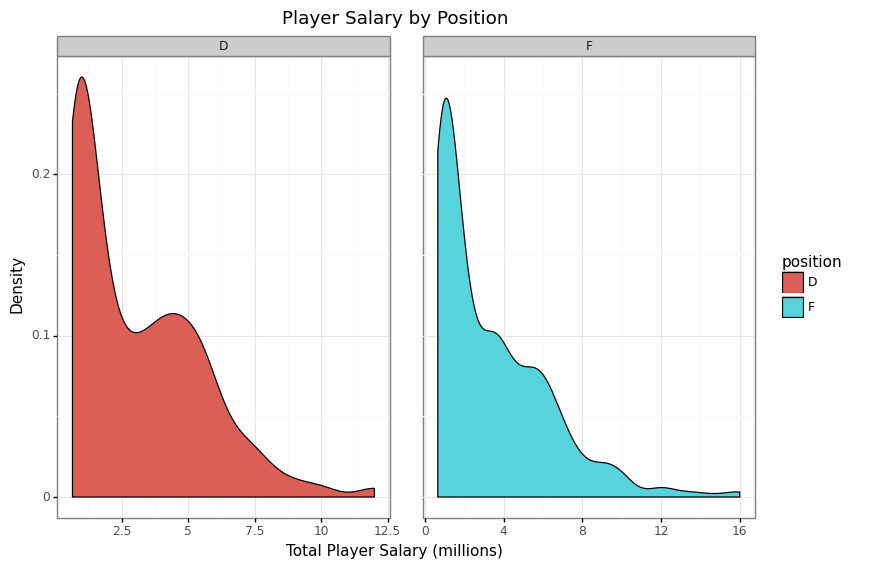

<ggplot: (349477117)>

In [15]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "total_salary", fill = "position")) + 
    geom_density() + 
    theme_bw() + 
    labs(x = "Total Player Salary (millions)", y = "Density", title = "Player Salary by Position") +
    facet_wrap(" ~ position", scales = "free_x") + 
    theme(subplots_adjust={'wspace': 0.1})
)

There is a fairly similar distribution of salaries between the 2 positions.

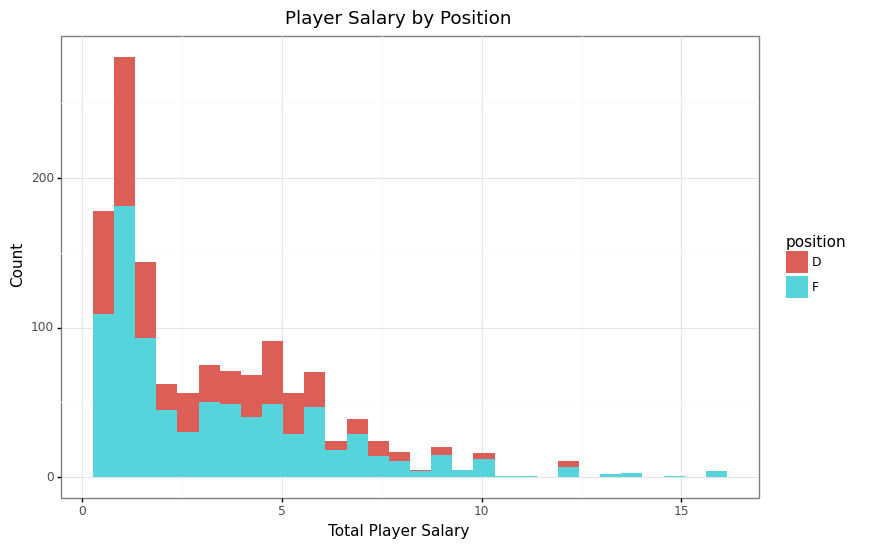

<ggplot: (349554646)>

In [16]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "total_salary", fill = "position")) + 
    geom_histogram(bins = 30) + 
    theme_bw() + 
    labs(x = "Total Player Salary", y = "Count", title = "Player Salary by Position") 
)

A stacked histogram gives us a little better look, and we can see that forwards seem to have a higher salary ceiling.

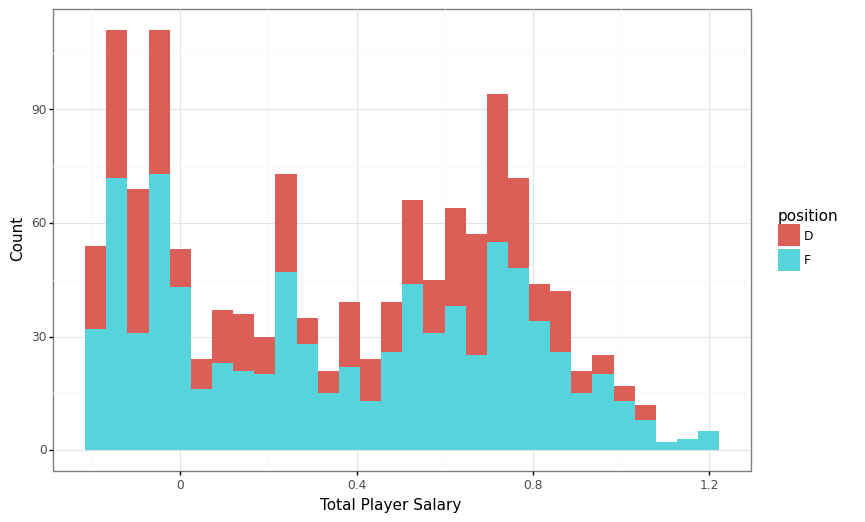

<ggplot: (349603118)>

In [17]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(log10_sal = np.log10(player_full.total_salary)), mapping = aes(x = "log10_sal", fill = "position")) + 
    geom_histogram(bins = 30) + 
    theme_bw() + 
    labs(x = "Total Player Salary", y = "Count") 
)

Since the salary distribution shows significant right skew, the above plot looks at the log10 transformation to see if log(salary) should be used. However, we now see a bimodal distribution. Untransformed salary will be used. A summary of the salary and cap hit distributions can be seen below.

In [18]:
player_full[['total_salary', "total_cap_hit"]].describe()
# checking how many players have an essentially missing cap hit
player_full.query('total_cap_hit < .5')

,total_salary,total_cap_hit
count,1325.000000,1325.000000
mean,3.246928,2.986098
std,2.705869,2.435503
min,0.650000,0.000000
25%,0.925000,0.894166
50%,2.350000,2.100000
75%,5.000000,4.850000
max,16.000000,12.500000


,fullName,total_salary,total_cap_hit,season,position,height,weight,rookie,shootsCatches,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
1305,Zach Bogosian,1.3,0.0,20192020,D,74.0,200,0,R,449.2,6,1,22,29,27,30,0,0,2.2,389.45,22,0.0,3.4,0,0,0,1,57.55,27,0,7,533,16.62,14.42,2.12,0.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,29.0,0,0,0.0,0.0


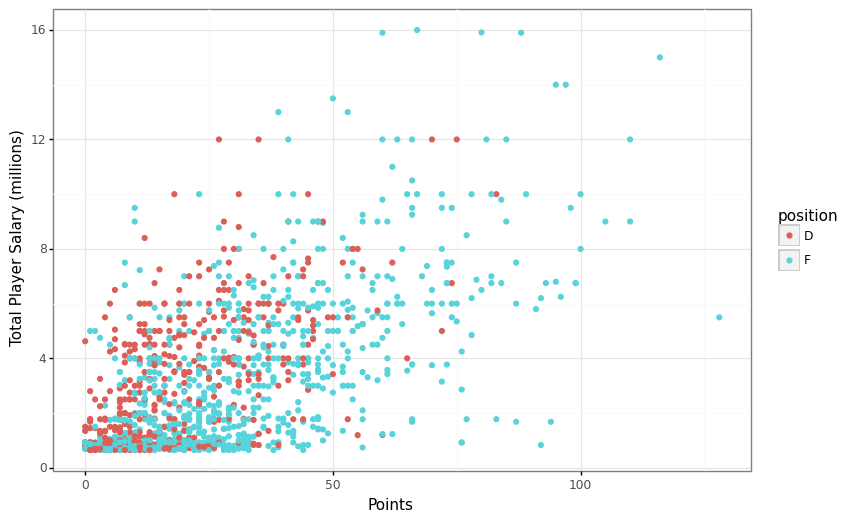

<ggplot: (349597986)>

In [19]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(points = player_full.goals + player_full.assists), mapping = aes(x = "points", y = "total_salary", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(y = "Total Player Salary (millions)", x = "Points")
)

In the scatterplot above, we can see that defensemen tend to make a higher salary despite the fact that they produce few points in general. However, this makes sense and gives a hint of the Simpson's paradox we will run into below.

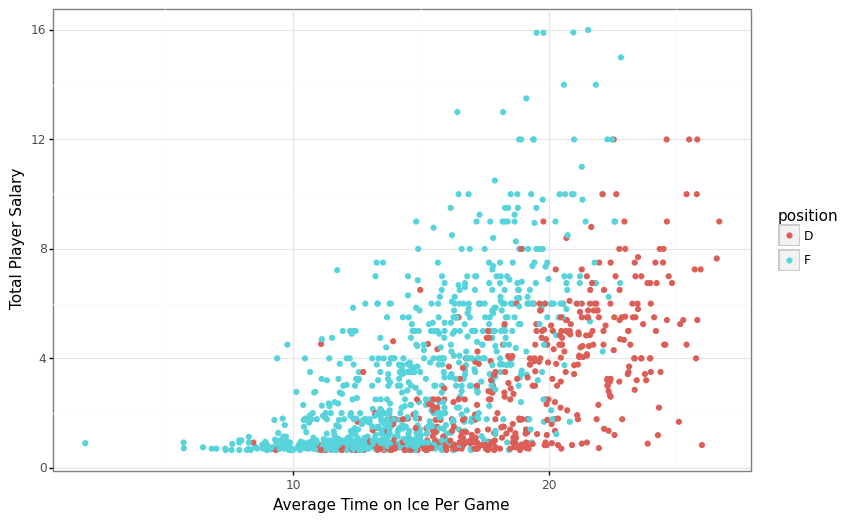

<ggplot: (349603217)>

In [20]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "timeOnIcePerGame", y = "total_salary", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(y = "Total Player Salary", x = "Average Time on Ice Per Game")
)

Defensemen average more time on ice per game than forwards.

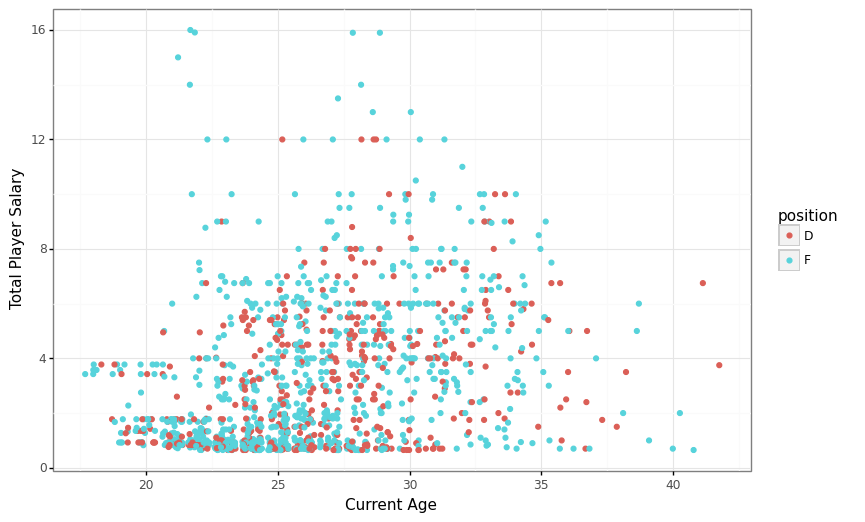

<ggplot: (349744240)>

In [21]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "currentAge", y = "total_salary", color = "position")) + 
    geom_jitter() + 
    theme_bw() + 
    labs(y = "Total Player Salary", x = "Current Age")
)

The scatterplot of age and salary shows that younger players (rookies) and older players tend to make less than those in their mid 20s.

/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/Users/sawyer/Desktop/data_science_denver/Spring_2021/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


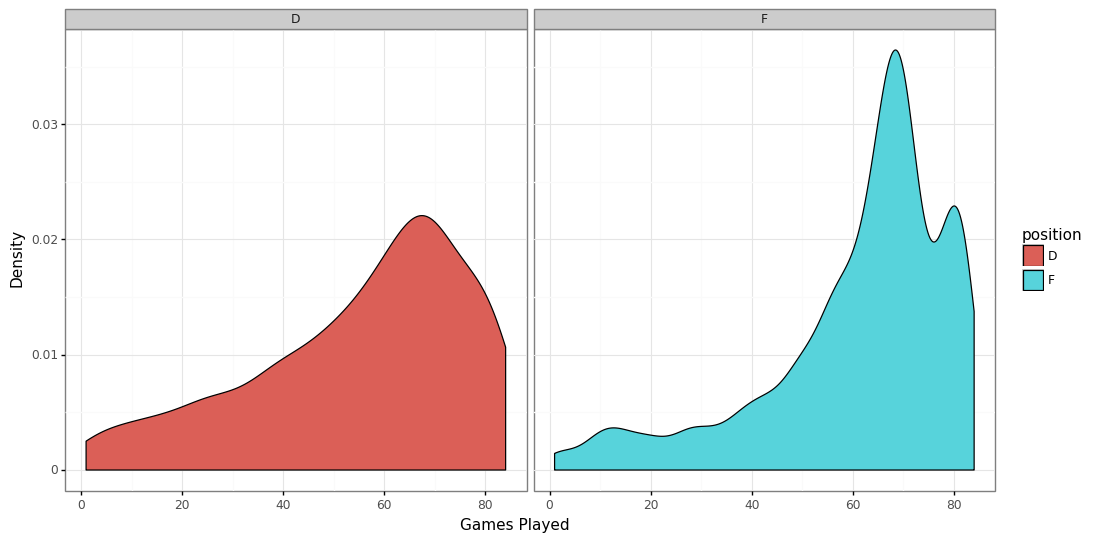

<ggplot: (349637446)>

In [22]:
plotnine.options.figure_size = (12, 6)

(
ggplot(data = player_full, mapping = aes(x = "games", fill = "position")) + 
    geom_density() + 
    theme_bw() + 
    labs(x = "Games Played", y = "Density") + 
    facet_grid(" ~ position")
)

It seems that forwards tend to play more games in a season than defensemen. This is likely due to injuries however.

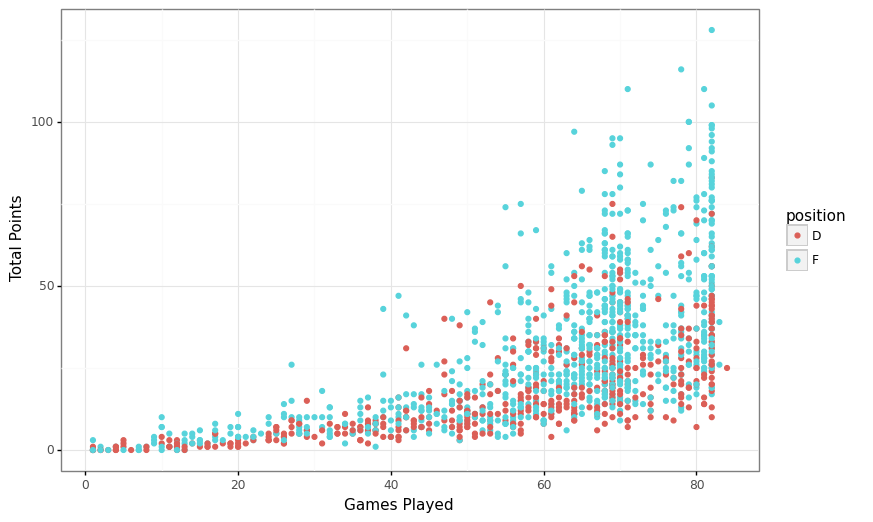

<ggplot: (349676304)>

In [23]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(points = player_full.goals + player_full.assists), mapping = aes(x = "games", y = "points", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Games Played", y = "Total Points")
)

There is clear sign of heteroscedasticity here for both positions, although more severe for forwards. This distribution is somewhat misleading however. Players who play less than say 30 games are either on the bubble or fighting through injuries. Neither are situations in which point production will thrive in.

<AxesSubplot:>

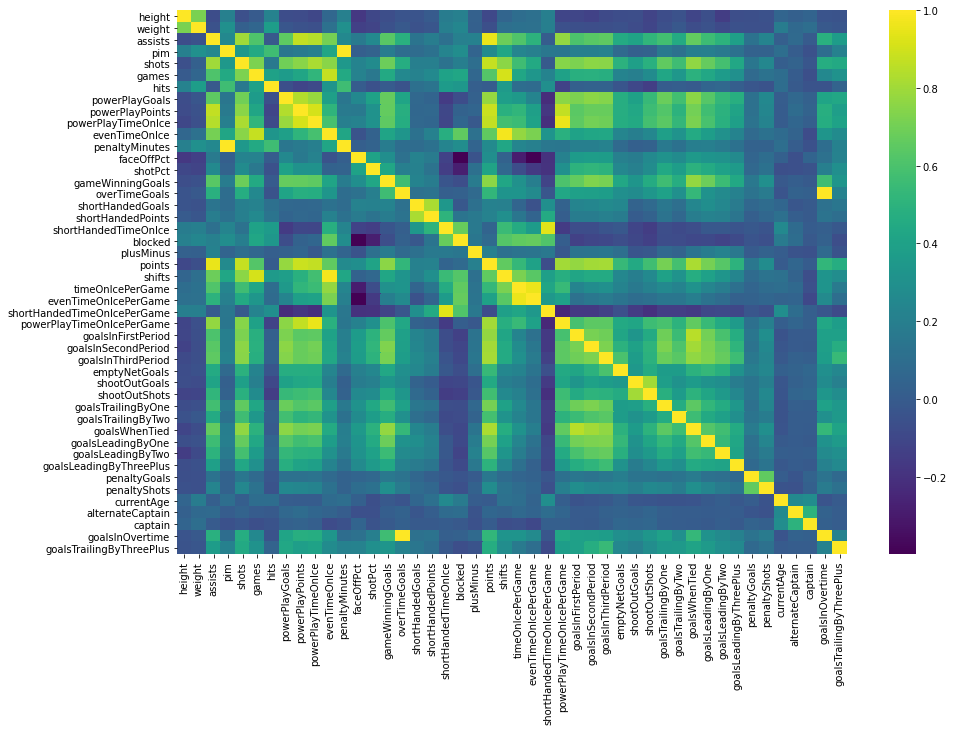

In [24]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(player_full.drop(columns = ['total_cap_hit', 'total_salary', 
                                     'fullName', 'season', 'goals', "timeOnIce", "rookie"]).corr(), ax = ax, cmap = "viridis")

## Prepping pipelines for modeling

# Model Fitting with all players (positions) included in one group

First we will do some cluster analyses to try to tease out distinct clusters in the forwards and defensemen. Theorically these should be more offensively/defensively inclined, but players playing fewer games will likely contribute to a difference as well. These will then be used in the models for predictions as well as plotted with some PCA variables to see how the clustering worked.

In [25]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

salary_data = player_full[['total_cap_hit', 'total_salary']].copy()

# dropping some columns that should not be used in the X data
# goals, for instance, is captured through the different goalsIn.. variables
X_full = player_full.drop(columns = ['total_cap_hit', 'total_salary', 
                                     'fullName', 'season', 'goals', "timeOnIce", "rookie"]).copy()


In [26]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_full, salary_data.total_salary, test_size=.3, random_state=42)

print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y Test shape:", y_test.shape)

X Train shape: (927, 48)
X Test shape: (398, 48)
y Train shape: (927,)
y Test shape: (398,)


In [27]:
# separating forwards and defensemen for cluster analysis 
forwards = (
    X_train[X_train.position == "F"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)

defense = (
    X_train[X_train.position == "D"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence = forwards.filter(regex="games|goals|assists|plus|shots")
defense_offence = defense.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

km_for = KMeans(n_clusters=3, random_state=42)
km_def = KMeans(n_clusters=3, random_state=42)

# storing the clusters
forwards['km_clust'] = km_for.fit_predict(forward_offence)

defense['km_clust'] = km_def.fit_predict(defense_offence) + 3

X_train = pd.concat([forwards, defense], axis='index', ignore_index=True)
X_train.head()
X_train.km_clust.value_counts()

,position,height,weight,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
0,F,75.0,212,L,12,12,112,55,88,12,17,158.83,736.80,12,35.48,17.00,2,0,0,0,1.27,17,-20,31,1006,16.30,13.38,0.20,2.88,7.0,6.0,6.0,0.0,0.0,0.0,3.0,3.0,6.0,2.0,2.0,2.0,0.0,0.0,32.0,0,0,0.0,1.0,2
1,F,74.0,205,L,34,64,174,82,115,2,9,188.55,1249.47,64,43.45,15.52,5,1,0,0,14.65,52,16,61,1820,17.70,15.23,0.17,2.28,11.0,6.0,9.0,1.0,1.0,1.0,4.0,2.0,11.0,6.0,2.0,2.0,0.0,0.0,20.0,0,0,1.0,0.0,0
2,F,68.0,176,R,14,6,148,44,18,3,8,100.35,615.37,6,47.36,8.10,2,1,0,0,69.47,21,2,26,1019,17.83,13.98,1.57,2.27,6.0,3.0,2.0,1.0,0.0,1.0,2.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0,30.0,0,0,1.0,0.0,2
3,F,75.0,195,L,2,2,36,54,59,0,0,1.32,493.72,2,42.47,5.60,0,0,0,0,67.12,18,-21,4,758,10.40,9.13,1.23,0.20,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1,1,0.0,0.0,1
4,F,73.0,195,L,19,24,105,81,28,0,1,26.33,1085.22,24,38.46,5.71,0,0,0,1,120.98,44,-4,25,1774,15.20,13.38,1.48,0.32,0.0,4.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,25.0,0,0,0.0,0.0,2


2    250
1    206
3    160
0    134
5    124
4     53
Name: km_clust, dtype: int64

In [28]:
# use PCA to visualize some of the clusters
from sklearn.decomposition import PCA

# initiating classes
pca_for = PCA(n_components=2)
pca_def = PCA(n_components=2)

# creating a dataset that will only have the clusters and the PCA variables in it
for_clust = pd.DataFrame(forwards.km_clust.astype(str))
def_clust = pd.DataFrame(defense.km_clust.astype(str))

pca_for.fit(forward_offence)
pca_def.fit(defense_offence)

pca_cols = ["pca_" + str(i) for i in range(pca_for.n_components_)]

# adding the PCA transformations to the dataframes
for_clust[pca_cols] = pca_for.transform(forward_offence)
def_clust[pca_cols] = pca_def.transform(defense_offence)

PCA(n_components=2)

PCA(n_components=2)

In [29]:
forwards.groupby('km_clust').median()

defense.groupby('km_clust').median()

,height,weight,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.0,198.0,32.5,28.0,203.0,73.0,55.0,6.0,16.0,202.965,1116.170,28.0,46.150,12.265,4.0,1.0,0.0,0.0,28.275,32.5,1.0,59.0,1670.5,18.670,15.22,0.500,2.830,7.5,8.5,8.0,1.0,1.0,3.0,4.0,2.0,9.0,5.0,3.0,1.0,0.0,0.0,26.0,0.0,0.0,1.0,1.0
1,73.0,198.0,5.5,14.0,50.5,47.0,52.0,0.0,0.0,5.265,474.915,14.0,44.160,9.030,1.0,0.0,0.0,0.0,8.835,19.0,-2.0,10.0,736.0,11.650,10.47,0.500,0.500,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
2,73.0,198.0,17.0,23.0,120.0,69.0,68.0,2.0,5.0,106.560,875.625,23.0,44.795,10.600,2.0,0.0,0.0,0.0,45.650,30.0,-1.0,31.0,1362.5,15.285,12.83,0.715,1.625,4.0,5.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0


,height,weight,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,73.5,205.0,14.5,27.0,96.0,68.0,81.0,0.0,1.0,20.385,1138.990,27.0,0.0,4.35,0.0,0.0,0.0,0.0,118.18,88.0,1.0,19.0,1605.0,19.46,16.91,1.80,0.70,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
4,75.0,215.0,28.0,34.0,170.0,78.0,75.0,3.0,11.0,171.900,1380.330,34.0,0.0,5.48,2.0,0.0,0.0,1.0,144.85,108.0,2.0,41.0,1972.0,23.30,18.82,2.12,2.65,2.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0
5,74.0,202.0,5.0,13.5,38.0,37.0,38.0,0.0,0.0,1.420,509.285,13.5,0.0,2.60,0.0,0.0,0.0,0.0,34.40,38.5,-1.0,6.0,735.0,15.55,14.19,1.18,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0


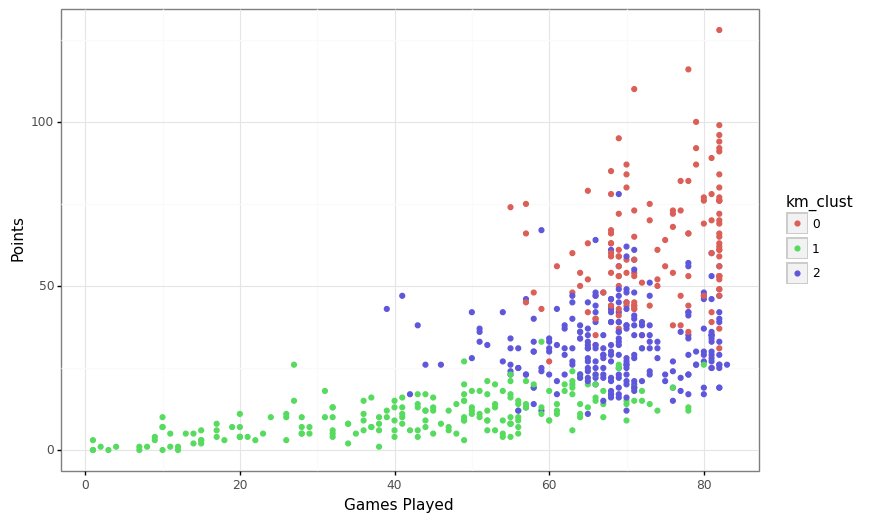

<ggplot: (350187511)>

In [30]:
(
ggplot(forwards.assign(km_clust = forwards.km_clust.astype(str)), aes(x = "games", y = "points", color = "km_clust")) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Games Played", y = "Points")
)

Clusters don't exactly look great... No clear distancing in them, but that is not unexpected

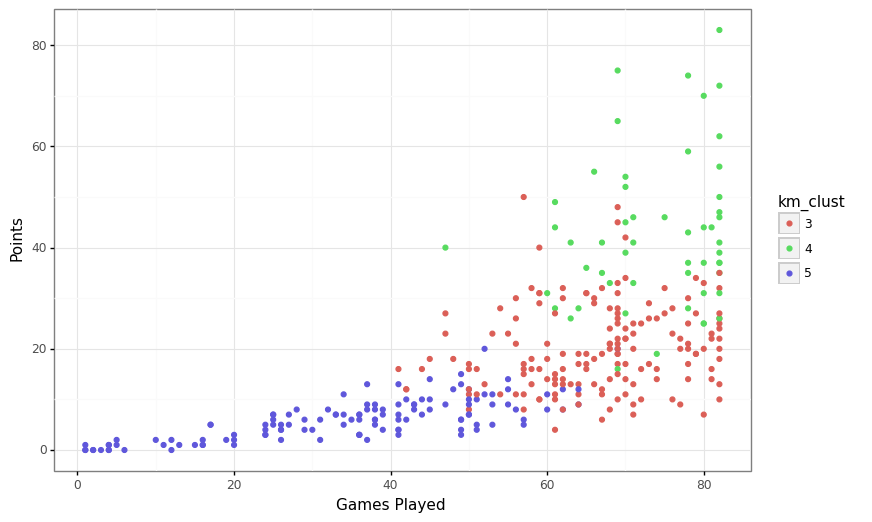

<ggplot: (349834165)>

In [31]:
(
ggplot(defense.assign(km_clust = defense.km_clust.astype(str)), aes(x = "games", y = "points", color = "km_clust")) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Games Played", y = "Points")
)

In [32]:
pca_for.explained_variance_ratio_

array([0.92467028, 0.03271344])

In [33]:
for_clust.km_clust.value_counts()
def_clust.km_clust.value_counts()

2    250
1    206
0    134
Name: km_clust, dtype: int64

3    160
5    124
4     53
Name: km_clust, dtype: int64

In [34]:
forwards.shape
defense.shape
X_train.shape

(590, 49)

(337, 49)

(927, 49)

# Model fitting for predictions

In [35]:
# importing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# bringing in model selection tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# adding trained clustering to the test set

# separating forwards and defensemen for cluster analysis 
forwards_test = (
    X_test[X_test.position == "F"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)

defense_test = (
    X_test[X_test.position == "D"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence_test = forwards_test.filter(regex="games|goals|assists|plus|shots")
defense_offence_test = defense_test.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

# storing the clusters
forwards_test['km_clust'] = km_for.predict(forward_offence_test)

defense_test['km_clust'] = km_def.predict(defense_offence_test) + 3

X_test = pd.concat([forwards_test, defense_test], axis='index', ignore_index=True)
X_test.head()
X_test.km_clust.value_counts()

,position,height,weight,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
0,F,74.0,195,L,14,91,159,63,97,1,3,76.18,786.28,91,0.00,6.29,1,0,0,0,0.27,27,-10,24,1113,13.68,12.47,0.00,1.20,3.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,1.0,0.0,0.0,23.0,1,0,0.0,1.0,2
1,F,75.0,231,L,14,91,74,79,259,2,4,106.12,939.52,91,55.55,8.11,0,0,0,0,0.00,22,-9,20,1422,13.23,11.88,0.00,1.33,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,30.0,0,0,0.0,1.0,1
2,F,71.0,180,L,16,24,92,62,56,1,4,110.62,743.98,24,53.84,7.61,1,0,0,0,0.00,28,-14,23,1128,13.78,11.98,0.00,1.78,3.0,0.0,4.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,24.0,1,1,0.0,0.0,2
3,F,71.0,185,R,63,24,229,82,28,2,23,288.40,1328.82,24,57.90,9.61,4,1,1,1,142.23,19,9,85,2138,21.45,16.20,1.73,3.52,6.0,7.0,8.0,1.0,1.0,4.0,4.0,2.0,7.0,2.0,4.0,0.0,0.0,0.0,30.0,0,1,1.0,3.0,0
4,F,70.0,192,L,7,10,114,74,200,0,0,2.90,815.98,10,31.25,7.89,1,0,2,2,126.45,52,-12,16,1425,12.77,11.20,1.70,0.30,2.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,23.0,0,0,0.0,1.0,2


2    128
1     84
5     56
3     54
0     47
4     29
Name: km_clust, dtype: int64

In [36]:
# numeric columns to scale
num_scale_vars = X_full.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["position", 'shootsCatches', 'km_clust']

# transformer to scale numeric columns using standard scaler
transform1 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


transformers = [transform1]


def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds, transformers = [], [], [], []
    # transforming the train and test datasets
    for transformer in transform:
        X_train_transformed = transformer.fit_transform(X_train)
        X_test_transformed = transformer.transform(X_test)
        # looping through the models
        for (name, clf), parms in zip(clfs.items(), params):
            # using GridSearchCV to find the optimal parameters for the data
            grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True)
            grid.fit(X_train_transformed, y_train)
            best_mod = grid.best_estimator_
            # creating predictions
            train_pred = best_mod.predict(X_train_transformed)
            test_pred = best_mod.predict(X_test_transformed)
            # calculating and printing accuracies
            train_acc = mean_squared_error(y_train, train_pred)
            test_acc = mean_squared_error(y_test, test_pred)
            print(name + " Training MSE:", train_acc)
            print(name + " Test MSE:", test_acc, "\n")
            # storing predictions and best CV models
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(best_mod)
        transformers.append(transformer)
    # return predictions, models, and transformed data
    return(best_mods, transformers, train_preds, test_preds, X_train_transformed, X_test_transformed)

# list of models we want to fit
mods = {
    "Linear_regression": LinearRegression(n_jobs=-1),
    "Random_Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=30, max_features="sqrt"),
    "KNN": KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=10),
    "Lasso": Lasso(random_state=42, alpha=1.0, max_iter=10000),
    "Ridge": Ridge(random_state=42, alpha=1.0, max_iter=1e4, solver="auto"),
    "XGBoost": GradientBoostingRegressor(random_state=42, criterion="mse", n_estimators=30, max_features="sqrt", learning_rate=.9, loss='ls')
}

params = [
    {
        'normalize': [True, False]
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'bootstrap': [True, False]
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    },
    {
        "alpha": [1]#np.linspace(.1, 1, num=10)
    },
    {
        "alpha": np.linspace(.1, 1, num=10),
        "solver": ['auto', 'svd', 'saga']
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'learning_rate': [.6, .9],
        'loss': ['ls', 'huber']
    }
]

import time
start = time.time()

best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
    X_train, y_train, X_test, y_test, mods, transformers, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear_regression Training MSE: 7.096835282846622
Linear_regression Test MSE: 7.362339432128907 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Random_Forest Training MSE: 6.8813566034197935
Random_Forest Test MSE: 7.15586971776544 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training MSE: 7.132516879570401
KNN Test MSE: 7.2319851173180565 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Lasso Training MSE: 7.421192143947118
Lasso Test MSE: 7.076650307584007 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Ridge Training MSE: 7.089780948606389
Ridge Test MSE: 7.359269571191178 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
XGBoost Training MSE: 5.700883044533736
XGBoost Test MSE: 8.14562395752099 

Model fitting took: 213.10789489746094 seconds


In [37]:
best_models

[LinearRegression(n_jobs=-1),
 RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=45,
                       n_jobs=-1, random_state=42),
 KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=30),
 Lasso(alpha=1, max_iter=10000, random_state=42),
 Ridge(max_iter=10000.0, random_state=42),
 GradientBoostingRegressor(criterion='mse', learning_rate=0.6, loss='huber',
                           max_features='sqrt', n_estimators=10,
                           random_state=42)]

In [38]:
# fitting the voting classifier as the ensemble model
from sklearn.ensemble import VotingRegressor
voting = VotingRegressor([
    ('linear', best_models[0]),
    ('rf', best_models[1]),
    ('knn', best_models[2]),
    ('lasso', best_models[3]),
    ('ridge', best_models[4]),
    ('xgboost', best_models[5])
])

voting.fit(X_train_transformed, y_train)
voting.score(X_train_transformed, y_train)
voting_train_preds = voting.predict(X_train_transformed)
voting_test_preds = voting.predict(X_test_transformed)
mean_squared_error(y_train, voting_train_preds)
mean_squared_error(y_test, voting_test_preds)

VotingRegressor(estimators=[('linear', LinearRegression(n_jobs=-1)),
                            ('rf',
                             RandomForestRegressor(max_depth=3,
                                                   max_features='sqrt',
                                                   n_estimators=45, n_jobs=-1,
                                                   random_state=42)),
                            ('knn',
                             KNeighborsRegressor(metric='manhattan', n_jobs=-1,
                                                 n_neighbors=30)),
                            ('lasso',
                             Lasso(alpha=1, max_iter=10000, random_state=42)),
                            ('ridge', Ridge(max_iter=10000.0, random_state=42)),
                            ('xgboost',
                             GradientBoostingRegressor(criterion='mse',
                                                       learning_rate=0.6,
                                            

0.09786544702789302

6.694913857299845

7.190203441961346

In [39]:
best_models.append(voting)
train_preds.append(voting_train_preds)
test_preds.append(voting_test_preds)

In [40]:
# test_preds[0]

In [41]:
test_lin_mod = LinearRegression()

test_lin_mod.fit(X_train.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_train)

test_mod_preds = test_lin_mod.predict(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15])

mean_squared_error(test_mod_preds, y_test)

# test_lin_mod.score(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_test)
from sklearn.metrics import r2_score
r2_score(y_test, test_mod_preds)

LinearRegression()

7.14060283166446

-0.011414629241124574

In [42]:
salary_data.total_cap_hit.median()
salary_data.total_salary.median()

2.1

2.35

In [43]:
best_models[3].coef_

array([-0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,
       -0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
        0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,
        0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.])

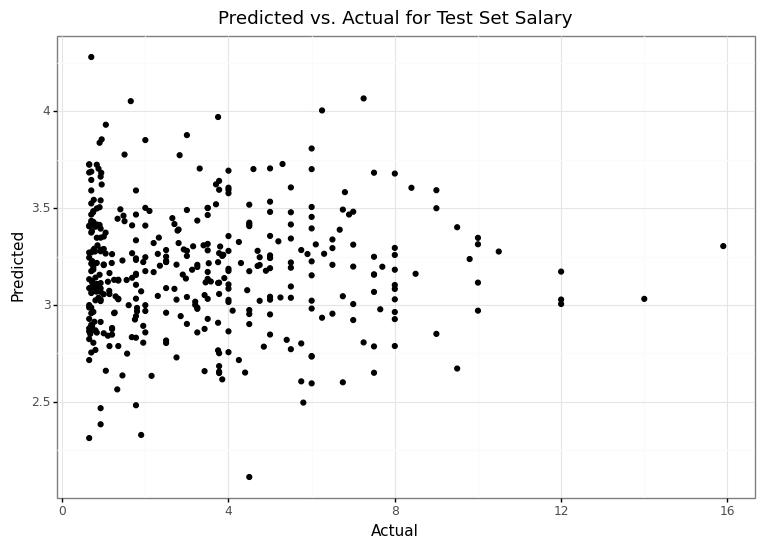

<ggplot: (352628580)>

In [44]:
check_preds = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['true', 'preds'])

(
ggplot(check_preds, aes(x = 'true', y = 'preds')) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Actual", y = "Predicted", title = "Predicted vs. Actual for Test Set Salary")
)

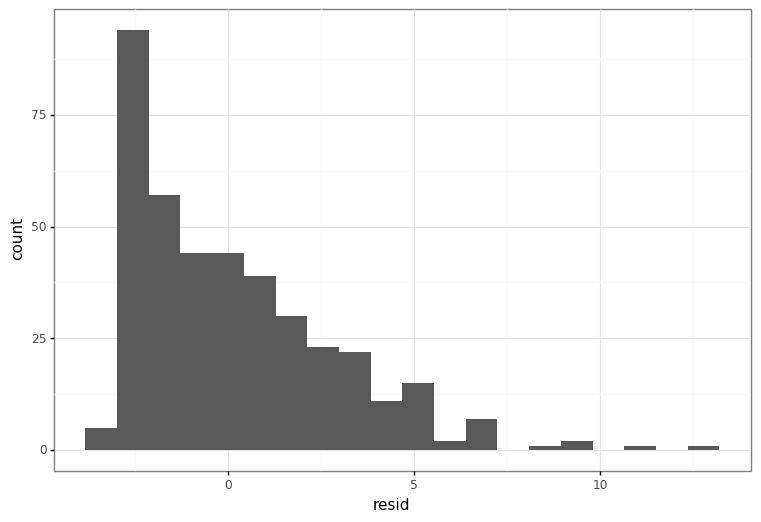

<ggplot: (352720839)>

In [45]:
resid = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['actual', 'preds'])

resid = resid.assign(resid = resid.actual - resid.preds)

(
ggplot(resid, aes(x = "resid")) + 
    geom_histogram(bins = 20) + 
    theme_bw()
)


In [46]:
resid

,actual,preds,resid
0,2.5000,2.959762,-0.459762
1,0.8325,2.857341,-2.024841
2,7.0000,2.921994,4.078006
3,0.6500,2.863459,-2.213459
4,5.2000,3.328523,1.871477
...,...,...,...
393,1.0000,3.289023,-2.289023
394,6.0000,2.981347,3.018653
395,8.0000,3.029116,4.970884
396,1.1325,3.072945,-1.940445


In [47]:
y_train.mean()

# train_preds[1]

3.2081862028047468

In [48]:
test_mse = [mean_squared_error(preds, y_test) for preds in test_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_df = pd.DataFrame(zip(mod_names, test_mse), columns = ['model', "mse"])

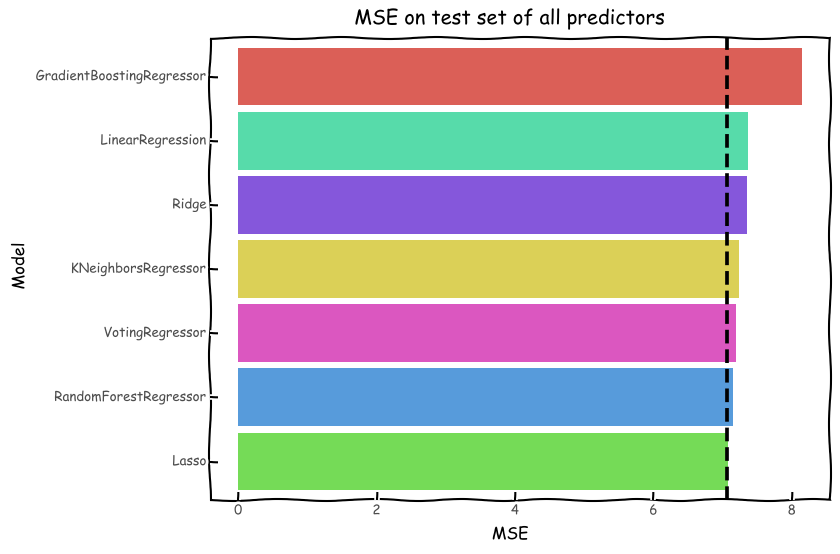

<ggplot: (352660218)>

In [49]:
mean_pred = np.mean((y_test - y_test.mean())**2)

mse_df = mse_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_df['model'], categories=mse_df['model'])

# assign to a new column in the DataFrame
mse_df = mse_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on test set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [50]:
train_mse = [mean_squared_error(preds, y_train) for preds in train_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_train_df = pd.DataFrame(zip(mod_names, train_mse), columns = ['model', "mse"])

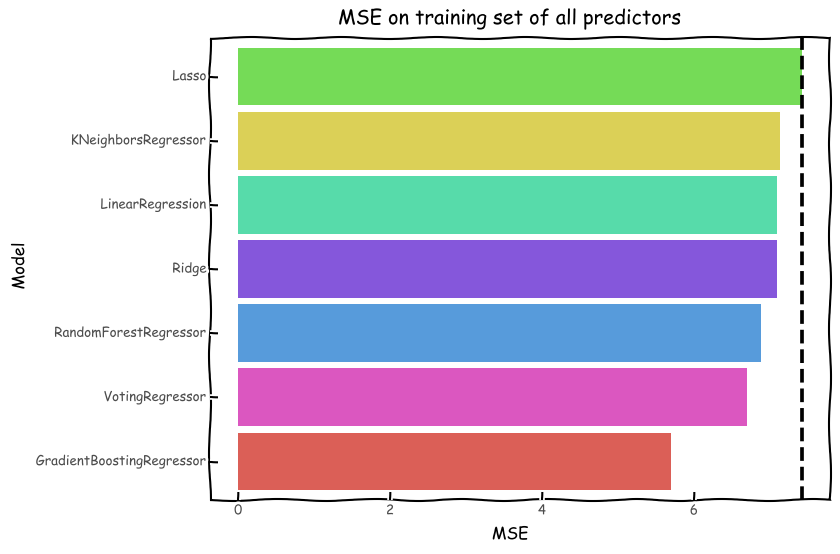

<ggplot: (349693419)>

In [51]:
mean_pred = np.mean((y_train - y_train.mean())**2)

mse_train_df = mse_train_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_train_df['model'], categories=mse_train_df['model'])

# assign to a new column in the DataFrame
mse_train_df = mse_train_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_train_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on training set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

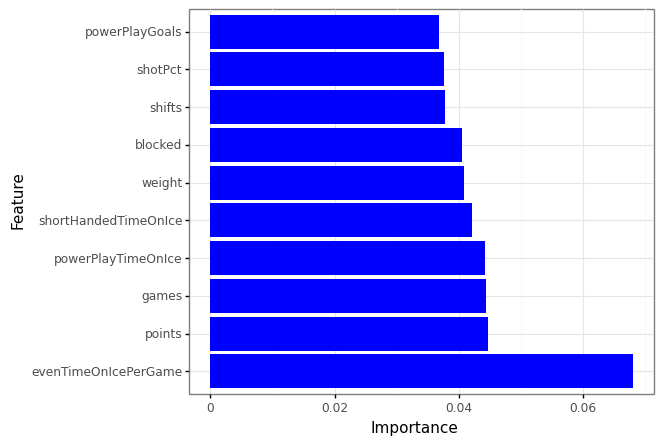

<ggplot: (349612304)>

In [52]:
# top 10 feature importances of the top Random Forest model
rf_features = pd.DataFrame(
    zip(transformer[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.to_list(), 
        best_models[1].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance") + 
    coord_flip() + 
    theme_bw()
)

# Splitting by Forwards and Defense for predictions

This should work much better since a good forward and a good defenseman will look COMPLETELY different on the score sheet.

In [53]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


time_on_ice_cols = ['evenTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame', 
                    'powerPlayTimeOnIcePerGame']
# splitting the positions
forwards_full = player_full[player_full.position == "F"].copy()
defense_full = player_full[player_full.position == "D"].copy()

# separating the salary data
salary_forwards = forwards_full[['total_cap_hit', 'total_salary']].copy()

salary_defense = defense_full[['total_cap_hit', 'total_salary']].copy()

# dropping some columns that should not be used in the X data
# goals, for instance, is captured through the different goalsIn.. variables
X_forwards = forwards_full.drop(columns = ['total_cap_hit', 'total_salary', 
                                        'fullName', 'season', 'goals', 'position', 
                                        'timeOnIce', 'powerPlayTimeOnIce', 
                                        'evenTimeOnIce', 'shortHandedTimeOnIce', 
                                        'timeOnIcePerGame', 'points']).copy()
X_defense = defense_full.drop(columns = ['total_cap_hit', 'total_salary', 
                                        'fullName', 'season', 'goals', 'position', 
                                        'penaltyGoals', "penaltyShots", 
                                        'timeOnIce', 'powerPlayTimeOnIce', 
                                        'evenTimeOnIce', 'shortHandedTimeOnIce', 
                                        'timeOnIcePerGame', 'points']).copy()

X_forwards.shape
X_defense.shape

(849, 43)

(476, 41)

<AxesSubplot:>

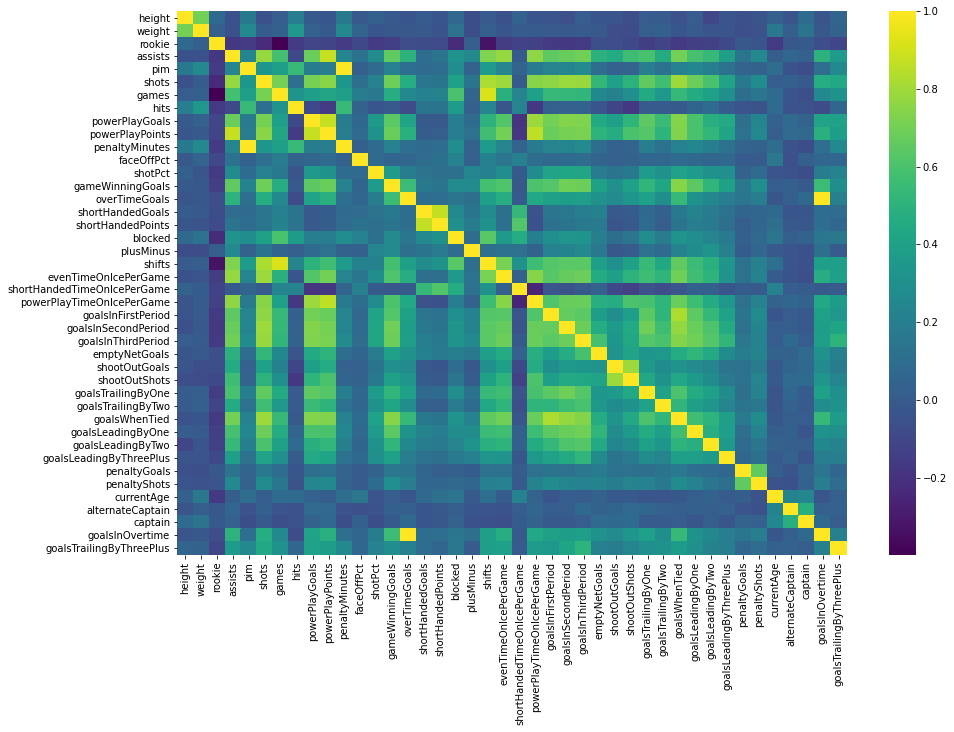

In [54]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(X_forwards.corr(), ax = ax, cmap = "viridis")

<AxesSubplot:>

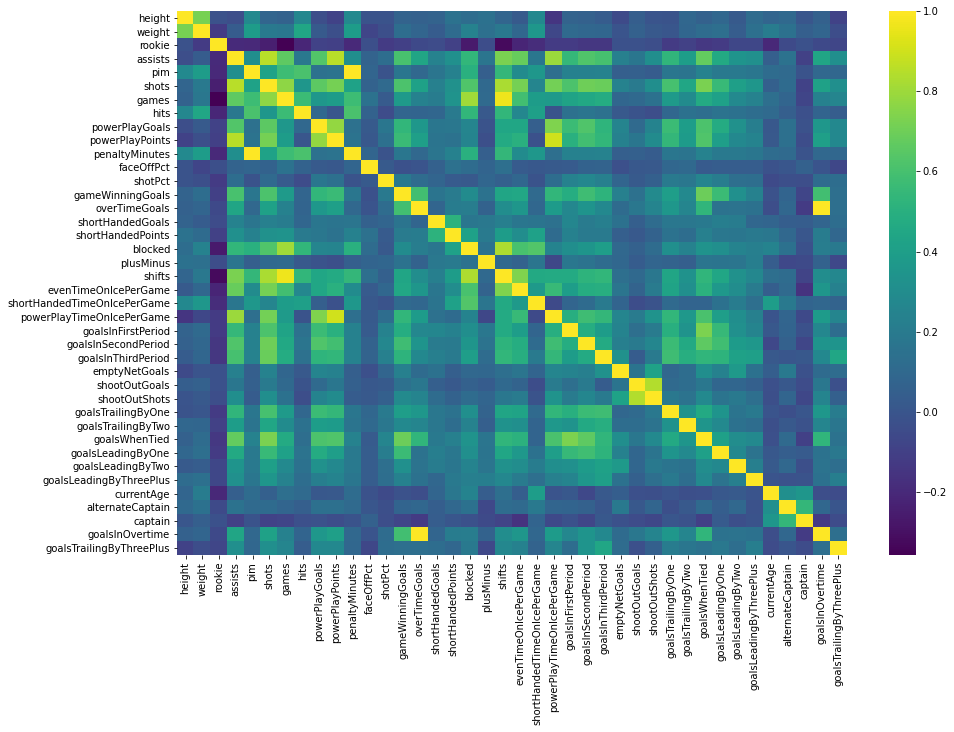

In [55]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(X_defense.corr(), ax = ax, cmap = "viridis")

# Forwards Predictions

In [56]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_forwards, salary_forwards.total_salary, test_size=.3, random_state=42)

print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y Test shape:", y_test.shape)

X Train shape: (594, 43)
X Test shape: (255, 43)
y Train shape: (594,)
y Test shape: (255,)


In [57]:
# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence = X_train.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

km_for = KMeans(n_clusters=3, random_state=42)

# storing the clusters
X_train['km_clust'] = km_for.fit_predict(forward_offence)


X_train.head()
X_train.km_clust.value_counts()

<ipython-input-57-ba18316bd245>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,height,weight,rookie,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
201,73.0,208,0,R,29,14,169,57,28,5,14,14,36.66,9.50,3,0,0,0,14,4,1280,14.42,0.20,4.12,7.0,3.0,6.0,0.0,0.0,5.0,5.0,2.0,3.0,3.0,1.0,1.0,0.0,0.0,22.0,0,0,0.0,1.0,1
1103,73.0,216,0,L,49,12,234,82,31,6,22,12,56.85,11.97,5,2,1,3,36,22,2103,15.90,1.98,2.85,12.0,8.0,6.0,1.0,2.0,5.0,4.0,2.0,10.0,5.0,5.0,0.0,0.0,0.0,27.0,0,1,2.0,2.0,1
665,76.0,227,1,R,3,8,10,17,15,0,0,8,33.33,0.00,0,0,0,0,7,1,218,8.20,0.00,0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0,0,0.0,0.0,2
205,76.0,212,0,L,28,32,175,68,49,4,7,32,51.76,14.90,5,3,0,0,44,6,1649,15.25,1.57,2.20,5.0,6.0,12.0,0.0,1.0,2.0,9.0,1.0,6.0,3.0,2.0,2.0,0.0,0.0,28.0,0,0,3.0,3.0,1
260,73.0,204,0,L,39,26,116,81,30,0,10,26,50.91,7.76,1,0,0,0,54,-22,1737,13.62,1.68,1.72,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,24.0,0,0,0.0,1.0,0


0    273
1    168
2    153
Name: km_clust, dtype: int64

In [58]:
# use PCA to visualize some of the clusters
from sklearn.decomposition import PCA

# initiating classes
pca_for = PCA(n_components=2)

# creating a dataset that will only have the clusters and the PCA variables in it
for_clust = pd.DataFrame(X_train.km_clust.astype(str))

pca_for.fit(forward_offence)

pca_cols = ["pca_" + str(i) for i in range(pca_for.n_components_)]

# adding the PCA transformations to the dataframes
for_clust[pca_cols] = pca_for.transform(forward_offence)

PCA(n_components=2)

In [59]:
X_train.groupby('km_clust').median()

,height,weight,rookie,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.0,196,0,15,24,109,68,64,1,4,24,45.73,10.30,2,0,0,0,30,-2,1293,12.47,0.70,1.37,3.0,4.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,26.0,0,0,0.0,0.0
1,72.0,197,0,30,29,193,73,54,5,15,29,45.19,12.23,4,0,0,0,34,0,1636,14.79,0.50,2.80,7.0,8.0,8.0,1.0,0.0,2.0,4.0,2.0,8.0,4.0,2.0,1.0,0.0,0.0,26.0,0,0,0.0,1.0
2,73.0,200,0,5,12,43,42,42,0,0,12,43.75,9.52,0,0,0,0,16,-1,653,10.40,0.38,0.43,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0,0,0.0,0.0


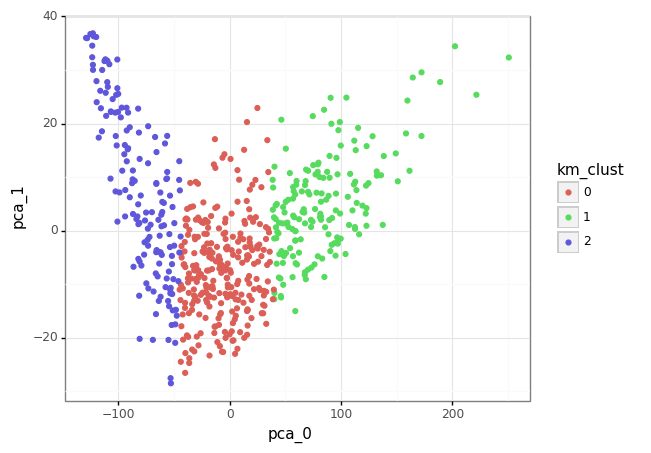

<ggplot: (352887459)>

In [60]:
(
ggplot(for_clust, aes(x = "pca_0", y = "pca_1", color = "km_clust")) + 
    geom_point() + 
    theme_bw()
)

Clusters don't exactly look great... No clear distancing in them, but that is not unexpected in clustering like this. There does appear to be a notable difference between the different clusters in offensive capabilities.

In [61]:
pca_for.explained_variance_ratio_

array([0.91957837, 0.03474222])

In [62]:
X_train.shape

(594, 44)

# Model fitting for predictions

In [63]:
# importing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# bringing in model selection tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# adding trained clustering to the test set


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence_test = X_test.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen

# storing the clusters
X_test['km_clust'] = km_for.predict(forward_offence_test)

X_test.head()
X_test.km_clust.value_counts()

<ipython-input-63-420d0d92e40f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,height,weight,rookie,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
808,68.0,175,0,L,28,24,104,48,57,3,15,24,33.33,11.54,1,0,0,0,43,-8,1129,15.33,1.5,2.98,4.0,5.0,3.0,0.0,2.0,5.0,3.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,31.0,0,0,0.0,2.0,0
560,71.0,192,0,L,21,21,111,60,53,7,12,21,29.26,18.00,4,0,0,0,23,-4,1185,13.93,0.1,2.28,5.0,9.0,6.0,0.0,0.0,0.0,2.0,4.0,7.0,2.0,3.0,2.0,0.0,0.0,27.0,0,0,0.0,0.0,0
158,73.0,180,0,L,2,8,24,16,16,0,0,8,66.66,0.00,0,0,0,0,5,-4,237,10.80,0.0,1.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0,0,0.0,0.0,2
1076,71.0,180,0,L,2,0,23,15,19,0,0,0,0.00,4.30,1,0,0,0,7,-2,256,10.45,0.0,1.68,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,0,0,0.0,0.0,2
58,75.0,201,0,L,13,14,100,76,35,1,1,14,35.00,12.00,4,0,0,0,29,2,1060,10.83,0.3,0.23,6.0,3.0,3.0,0.0,0.0,0.0,0.0,2.0,6.0,2.0,1.0,1.0,0.0,0.0,23.0,0,0,0.0,0.0,0


0    115
2     82
1     58
Name: km_clust, dtype: int64

In [64]:
# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ['shootsCatches', 'km_clust']

# transformer to scale numeric columns using standard scaler
transform1 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


transformers = [transform1]


def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds, transformers = [], [], [], []
    # transforming the train and test datasets
    for transformer in transform:
        X_train_transformed = transformer.fit_transform(X_train)
        X_test_transformed = transformer.transform(X_test)
        # looping through the models
        for (name, clf), parms in zip(clfs.items(), params):
            # using GridSearchCV to find the optimal parameters for the data
            grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True)
            grid.fit(X_train_transformed, y_train)
            best_mod = grid.best_estimator_
            # creating predictions
            train_pred = best_mod.predict(X_train_transformed)
            test_pred = best_mod.predict(X_test_transformed)
            # calculating and printing accuracies
            train_acc = mean_squared_error(y_train, train_pred)
            test_acc = mean_squared_error(y_test, test_pred)
            print(name + " Training MSE:", train_acc)
            print(name + " Test MSE:", test_acc, "\n")
            # storing predictions and best CV models
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(best_mod)
        transformers.append(transformer)
    # return predictions, models, and transformed data
    return(best_mods, transformers, train_preds, test_preds, X_train_transformed, X_test_transformed)

# list of models we want to fit
mods = {
    "Linear_regression": LinearRegression(n_jobs=-1),
    "Random_Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=30, max_features="sqrt"),
    "KNN": KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=10),
    "Lasso": Lasso(random_state=42, alpha=1.0, max_iter=10000),
    "Ridge": Ridge(random_state=42, alpha=1.0, max_iter=1e4, solver="auto"),
    "XGBoost": GradientBoostingRegressor(random_state=42, criterion="mse", n_estimators=30, max_features="sqrt", learning_rate=.9, loss='ls')
}

params = [
    {
        'normalize': [True, False]
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'bootstrap': [True, False]
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    },
    {
        "alpha": np.linspace(.1, 1, num=10)
    },
    {
        "alpha": np.linspace(.1, 1, num=10),
        "solver": ['auto', 'svd', 'saga']
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'learning_rate': [.6, .9],
        'loss': ['ls', 'huber']
    }
]

import time
start = time.time()

best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
    X_train, y_train, X_test, y_test, mods, transformers, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear_regression Training MSE: 3.0790168574054344
Linear_regression Test MSE: 3.466670401436041 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Random_Forest Training MSE: 0.46888580008149194
Random_Forest Test MSE: 3.1404783047616327 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training MSE: 0.0
KNN Test MSE: 4.043157756431764 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Lasso Training MSE: 3.3397467251954334
Lasso Test MSE: 3.230571510437364 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Ridge Training MSE: 3.077817982117301
Ridge Test MSE: 3.4660845285826265 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
XGBoost Training MSE: 1.7443903684002524
XGBoost Test MSE: 3.342735394907605 

Model fitting took: 145.18632817268372 seconds


In [65]:
best_models

[LinearRegression(n_jobs=-1),
 RandomForestRegressor(max_depth=12, n_estimators=35, n_jobs=-1, random_state=42),
 KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=10,
                     weights='distance'),
 Lasso(alpha=0.1, max_iter=10000, random_state=42),
 Ridge(max_iter=10000.0, random_state=42, solver='saga'),
 GradientBoostingRegressor(criterion='mse', learning_rate=0.6, loss='huber',
                           max_features='auto', n_estimators=10,
                           random_state=42)]

In [66]:
# fitting the voting classifier as the ensemble model
from sklearn.ensemble import VotingRegressor
voting = VotingRegressor([
    ('linear', best_models[0]),
    ('rf', best_models[1]),
#     ('knn', best_models[2]),
    ('lasso', best_models[3]),
    ('ridge', best_models[4]),
    ('xgboost', best_models[5])
])

voting.fit(X_train_transformed, y_train)
voting.score(X_train_transformed, y_train)
voting.score(X_test_transformed, y_test)
voting_train_preds = voting.predict(X_train_transformed)
voting_test_preds = voting.predict(X_test_transformed)
mean_squared_error(y_train, voting_train_preds)
mean_squared_error(y_test, voting_test_preds)

VotingRegressor(estimators=[('linear', LinearRegression(n_jobs=-1)),
                            ('rf',
                             RandomForestRegressor(max_depth=12,
                                                   n_estimators=35, n_jobs=-1,
                                                   random_state=42)),
                            ('lasso',
                             Lasso(alpha=0.1, max_iter=10000, random_state=42)),
                            ('ridge',
                             Ridge(max_iter=10000.0, random_state=42,
                                   solver='saga')),
                            ('xgboost',
                             GradientBoostingRegressor(criterion='mse',
                                                       learning_rate=0.6,
                                                       loss='huber',
                                                       max_features='auto',
                                                       n_estimators=10,


0.7597534810140958

0.6379349471899409

1.9491749768434738

3.0107668747575844

In [67]:
best_models.append(voting)
train_preds.append(voting_train_preds)
test_preds.append(voting_test_preds)

In [68]:
# test_preds[0]
X_train.drop(columns = ['shootsCatches']).iloc[:, 1:13].head()

,weight,rookie,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct
201,208,0,29,14,169,57,28,5,14,14,36.66,9.50
1103,216,0,49,12,234,82,31,6,22,12,56.85,11.97
665,227,1,3,8,10,17,15,0,0,8,33.33,0.00
205,212,0,28,32,175,68,49,4,7,32,51.76,14.90
260,204,0,39,26,116,81,30,0,10,26,50.91,7.76


In [69]:
# testing to see if using the more traditional statistics affects performance for a simple linear model
test_lin_mod = LinearRegression()

test_lin_mod.fit(X_train.drop(columns = ['shootsCatches']).iloc[:, 1:13], y_train)

test_mod_preds = test_lin_mod.predict(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:13])

mean_squared_error(test_mod_preds, y_test)

# test_lin_mod.score(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_test)
best_models[0].score(X_train_transformed, y_train)
from sklearn.metrics import r2_score
r2_score(y_test, test_mod_preds)

LinearRegression()

4.155254701287435

0.6204942651744413

0.5003025556463864

In [70]:
salary_forwards.total_cap_hit.median()
salary_forwards.total_salary.median()

2.0

2.3

In [71]:
# printing out and plotting the non-zero lasso coefficients
full_col_names = transformers[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.tolist()
# printing out the variables and their coefficient estimates
print("Intercept:", best_models[3].intercept_)
for var, coef in zip(full_col_names, best_models[3].coef_):
    print(var, ": ", coef, sep='')

Intercept: 3.2939143518518526
shootsCatches_L: 0.0
shootsCatches_R: -0.0
km_clust_0: -0.0
km_clust_1: 0.0
km_clust_2: 0.0
height: 0.025839864961241205
weight: 0.09675003769663036
rookie: -0.0
assists: 0.2497849345229134
pim: -0.0
shots: 0.0
games: -0.2519542978644883
hits: -0.0
powerPlayGoals: 0.0
powerPlayPoints: 0.2913497843376691
penaltyMinutes: -0.0
faceOffPct: 0.008123664550308642
shotPct: -0.0
gameWinningGoals: 0.0
overTimeGoals: 0.0
shortHandedGoals: -0.0
shortHandedPoints: -0.0
blocked: -0.0
plusMinus: 0.0
shifts: -0.0
evenTimeOnIcePerGame: 0.8525444618346117
shortHandedTimeOnIcePerGame: -0.0
powerPlayTimeOnIcePerGame: 0.3391568782975468
goalsInFirstPeriod: 0.009189042519103425
goalsInSecondPeriod: -0.0
goalsInThirdPeriod: 0.09957235997365435
emptyNetGoals: 0.05710082130448712
shootOutGoals: 0.0
shootOutShots: 0.1312801679741214
goalsTrailingByOne: -0.0
goalsTrailingByTwo: 0.0
goalsWhenTied: 0.024217483974748228
goalsLeadingByOne: 0.0
goalsLeadingByTwo: 0.23722220158850046
goal

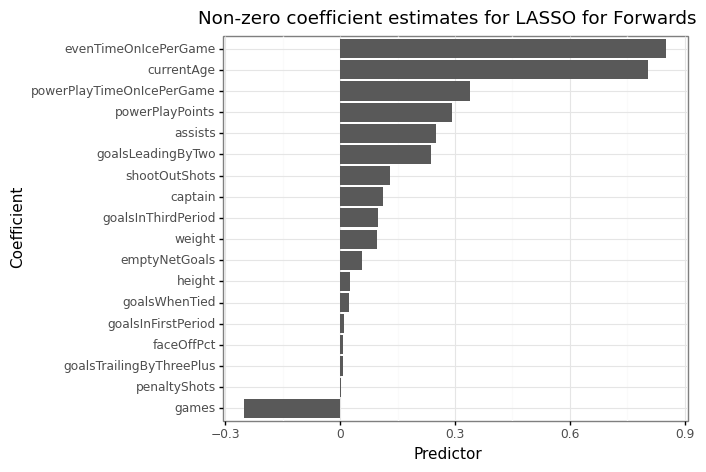

<ggplot: (352906927)>

In [72]:
forward_coefs = pd.DataFrame(zip(full_col_names, best_models[3].coef_), columns=["predictor", "coefficient"])
forward_coefs.sort_values(by=["coefficient"], ignore_index=True, inplace=True)

forward_coefs['predictor'] = pd.Categorical(forward_coefs['predictor'], categories=forward_coefs['predictor'], ordered=True)
# plot of the coefficients for each variable in the model
(
ggplot(data=forward_coefs.query("coefficient != 0"), mapping=aes(x="predictor", y="coefficient")) + 
    geom_bar(stat="identity") + 
    theme_bw() +
    labs(x = "Coefficient", y = "Predictor", title = "Non-zero coefficient estimates for LASSO for Forwards") + 
    coord_flip()
)

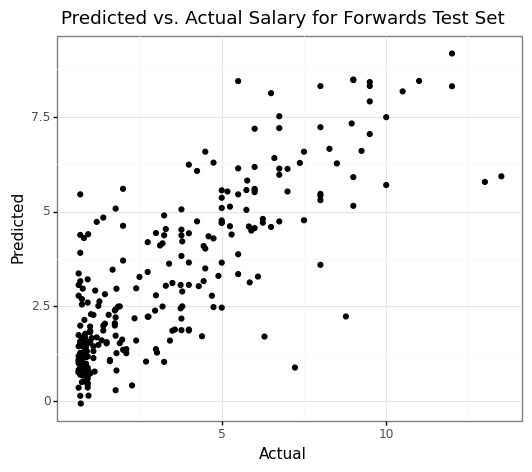

<ggplot: (352882990)>

In [73]:
check_preds = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['true', 'preds'])

(
ggplot(check_preds, aes(x = 'true', y = 'preds')) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Actual", y = "Predicted", title = "Predicted vs. Actual Salary for Forwards Test Set")
)

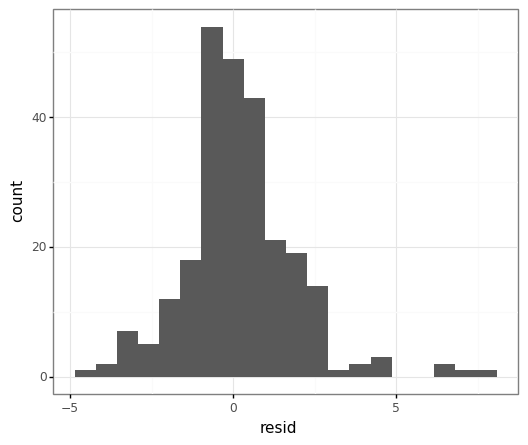

<ggplot: (352636407)>

In [74]:
resid = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['actual', 'preds'])

resid = resid.assign(resid = resid.actual - resid.preds)

(
ggplot(resid, aes(x = "resid")) + 
    geom_histogram(bins = 20) + 
    theme_bw()
)


In [75]:
resid

,actual,preds,resid
0,4.500,6.577465,-2.077465
1,6.250,4.706624,1.543376
2,0.775,2.968995,-2.193995
3,0.925,1.180806,-0.255806
4,3.250,1.037731,2.212269
...,...,...,...
250,1.800,1.267637,0.532363
251,4.000,3.657053,0.342947
252,6.500,8.119577,-1.619577
253,5.000,3.654316,1.345684


In [76]:
y_train.median()

# train_preds[1]

2.25

In [77]:
test_mse = [mean_squared_error(preds, y_test) for preds in test_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_df = pd.DataFrame(zip(mod_names, test_mse), columns = ['model', "mse"])

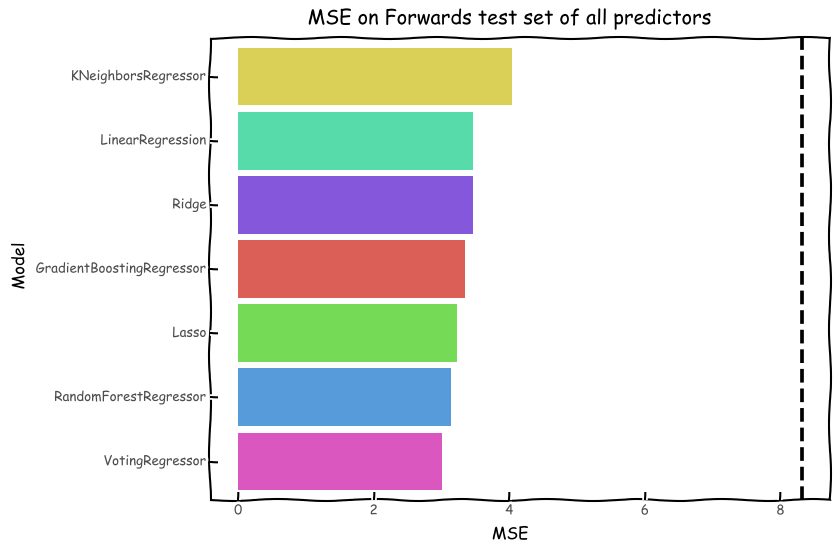

<ggplot: (349604533)>

In [78]:
mean_pred = np.mean((y_test - y_test.mean())**2)

mse_df = mse_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_df['model'], categories=mse_df['model'])

# assign to a new column in the DataFrame
mse_df = mse_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on Forwards test set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [79]:
train_mse = [mean_squared_error(preds, y_train) for preds in train_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_train_df = pd.DataFrame(zip(mod_names, train_mse), columns = ['model', "mse"])

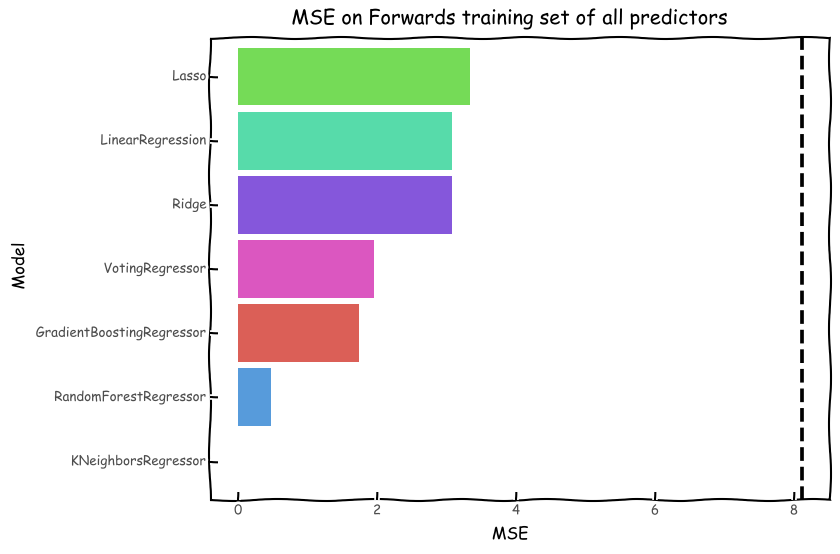

<ggplot: (352981492)>

In [80]:
mean_pred = np.mean((y_train - y_train.mean())**2)

mse_train_df = mse_train_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_train_df['model'], categories=mse_train_df['model'])

# assign to a new column in the DataFrame
mse_train_df = mse_train_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_train_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on Forwards training set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

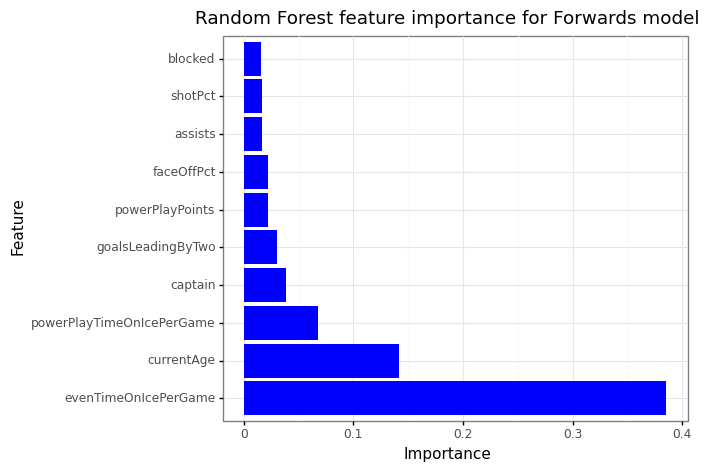

<ggplot: (352981426)>

In [81]:
# top 10 feature importances of the top Random Forest model
rf_features = pd.DataFrame(
    zip(transformer[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.to_list(), 
        best_models[1].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance", title = "Random Forest feature importance for Forwards model") + 
    coord_flip() + 
    theme_bw()
)

# Defense Predictions

In [82]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_defense, salary_defense.total_salary, test_size=.3, random_state=42)

print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y Test shape:", y_test.shape)

X Train shape: (333, 41)
X Test shape: (143, 41)
y Train shape: (333,)
y Test shape: (143,)


In [83]:
# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
defense_offence = X_train.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

km_for = KMeans(n_clusters=3, random_state=42)

# storing the clusters
X_train['km_clust'] = km_for.fit_predict(defense_offence)


X_train.head()
X_train.km_clust.value_counts()

<ipython-input-83-493748ed21f0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,height,weight,rookie,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
828,73.0,203,0,R,7,15,38,43,78,0,0,15,0.0,2.6,0,0,0,0,34,8,778,12.58,0.63,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0,0,0.0,0.0,0
1175,73.0,185,0,L,15,36,65,64,20,0,1,36,0.0,6.2,1,1,0,0,87,7,1672,18.17,1.65,0.62,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,29.0,0,0,1.0,0.0,2
97,71.0,186,0,R,14,14,89,69,68,0,0,14,0.0,5.6,3,0,0,1,96,-6,1785,18.48,2.48,0.80,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,33.0,0,0,0.0,0.0,2
784,73.0,200,0,L,26,34,157,60,42,2,11,34,0.0,3.2,0,0,0,2,148,2,1682,18.47,2.72,2.67,0.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,36.0,0,1,0.0,0.0,1
421,72.0,197,0,L,23,27,103,66,86,2,9,27,0.0,5.8,0,0,0,0,58,-9,1505,17.50,0.17,2.68,2.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,27.0,0,0,0.0,1.0,2


2    154
0    123
1     56
Name: km_clust, dtype: int64

In [84]:
# use PCA to visualize some of the clusters
from sklearn.decomposition import PCA

# initiating classes
pca_def = PCA(n_components=2)

# creating a dataset that will only have the clusters and the PCA variables in it
def_clust = pd.DataFrame(X_train.km_clust.astype(str))

pca_def.fit(defense_offence)

pca_cols = ["pca_" + str(i) for i in range(pca_def.n_components_)]

# adding the PCA transformations to the dataframes
def_clust[pca_cols] = pca_for.transform(defense_offence)

PCA(n_components=2)

In [85]:
X_train.groupby('km_clust').median()

,height,weight,rookie,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,74.0,200.0,0.0,4.0,12.0,34.0,34.0,38.0,0.0,0.0,12.0,0.0,2.700,0.0,0.0,0.0,0.0,35.0,0.0,656.0,14.300,1.200,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
1,74.0,209.5,0.0,29.0,33.5,165.5,72.0,73.0,2.0,11.0,33.5,0.0,5.475,2.0,0.0,0.0,1.0,108.0,3.5,1901.0,18.905,2.050,2.59,2.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0,28.0,0.0,0.0,0.0,0.0
2,74.0,205.0,0.0,14.0,32.0,95.5,68.0,84.0,0.0,1.0,32.0,0.0,4.250,0.0,0.0,0.0,0.0,90.0,1.5,1582.5,17.200,1.855,0.70,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,26.5,0.0,0.0,0.0,0.0


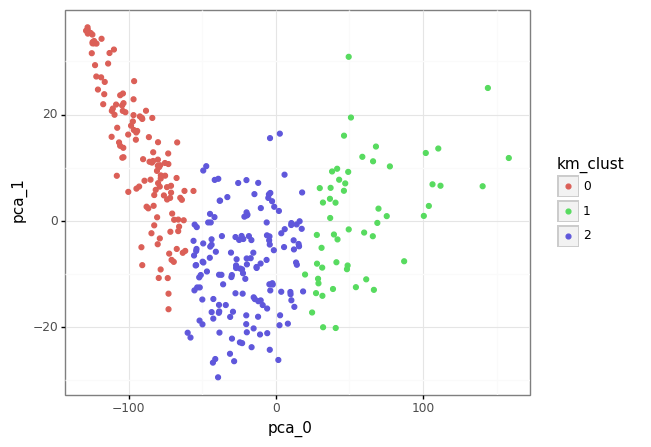

<ggplot: (349499772)>

In [86]:
(
ggplot(def_clust, aes(x = "pca_0", y = "pca_1", color = "km_clust")) + 
    geom_point() + 
    theme_bw()
)

Clusters don't exactly look great... No clear distancing in them, but that is not unexpected in clustering like this. There does appear to be a notable difference between the different clusters in offensive capabilities.

In [87]:
pca_def.explained_variance_ratio_

array([0.90333539, 0.04760295])

In [88]:
X_train.shape

(333, 42)

# Model fitting for predictions

In [89]:
# importing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# bringing in model selection tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# adding trained clustering to the test set


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence_test = X_test.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen

# storing the clusters
X_test['km_clust'] = km_for.predict(forward_offence_test)

X_test.head()
X_test.km_clust.value_counts()

<ipython-input-89-420d0d92e40f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,height,weight,rookie,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
1300,71.0,200,0,R,2,14,45,41,37,0,0,14,0.0,2.2,1,0,0,0,38,-1,767,13.70,0.23,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,31.0,0,0,0.0,0.0,0
120,78.0,231,0,L,4,56,50,51,89,0,0,56,0.0,2.0,0,0,0,0,69,-13,1176,15.13,2.45,0.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,0,0,0.0,0.0,0
376,73.0,204,0,L,8,32,54,51,104,0,0,32,0.0,3.7,1,0,0,0,77,-4,1241,18.52,1.37,0.12,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,29.0,0,0,0.0,1.0,0
220,73.0,195,0,L,5,10,42,29,93,0,0,10,0.0,2.4,0,0,0,0,73,10,685,17.12,2.68,0.10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,28.0,0,0,0.0,0.0,0
229,74.0,198,0,L,5,16,31,36,27,0,0,16,0.0,6.5,0,0,0,1,51,8,841,13.87,1.87,0.20,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,32.0,0,0,0.0,0.0,0


2    60
0    54
1    29
Name: km_clust, dtype: int64

In [90]:
# numeric columns to scale
num_scale_vars = X_train.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ['shootsCatches', 'km_clust']

# transformer to scale numeric columns using standard scaler
transform1 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


transformers = [transform1]


def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds, transformers = [], [], [], []
    # transforming the train and test datasets
    for transformer in transform:
        X_train_transformed = transformer.fit_transform(X_train)
        X_test_transformed = transformer.transform(X_test)
        # looping through the models
        for (name, clf), parms in zip(clfs.items(), params):
            # using GridSearchCV to find the optimal parameters for the data
            grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True)
            grid.fit(X_train_transformed, y_train)
            best_mod = grid.best_estimator_
            # creating predictions
            train_pred = best_mod.predict(X_train_transformed)
            test_pred = best_mod.predict(X_test_transformed)
            # calculating and printing accuracies
            train_acc = mean_squared_error(y_train, train_pred)
            test_acc = mean_squared_error(y_test, test_pred)
            print(name + " Training MSE:", train_acc)
            print(name + " Test MSE:", test_acc, "\n")
            # storing predictions and best CV models
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(best_mod)
        transformers.append(transformer)
    # return predictions, models, and transformed data
    return(best_mods, transformers, train_preds, test_preds, X_train_transformed, X_test_transformed)

# list of models we want to fit
mods = {
    "Linear_regression": LinearRegression(n_jobs=-1),
    "Random_Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=30, max_features="sqrt"),
    "KNN": KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=10),
    "Lasso": Lasso(random_state=42, alpha=1.0, max_iter=10000),
    "Ridge": Ridge(random_state=42, alpha=1.0, max_iter=1e4, solver="auto"),
    "XGBoost": GradientBoostingRegressor(random_state=42, criterion="mse", n_estimators=30, max_features="sqrt", learning_rate=.9, loss='ls')
}

params = [
    {
        'normalize': [True, False]
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'bootstrap': [True, False]
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    },
    {
        "alpha": np.linspace(.1, 1, num=10)
    },
    {
        "alpha": np.linspace(.1, 1, num=10),
        "solver": ['auto', 'svd', 'saga']
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'learning_rate': [.6, .9],
        'loss': ['ls', 'huber']
    }
]

import time
start = time.time()

best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
    X_train, y_train, X_test, y_test, mods, transformers, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear_regression Training MSE: 2.0660900840554097
Linear_regression Test MSE: 2.804884893663198 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Random_Forest Training MSE: 0.00788794978524159
Random_Forest Test MSE: 2.630287680700139 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training MSE: 0.0
KNN Test MSE: 3.2536758700794204 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Lasso Training MSE: 2.3742053219599213
Lasso Test MSE: 2.306114528037279 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Ridge Training MSE: 2.0640478462571066
Ridge Test MSE: 2.7800635063982893 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
XGBoost Training MSE: 1.0766168973968393
XGBoost Test MSE: 3.0570064024728887 

Model fitting took: 94.24919986724854 seconds


In [91]:
best_models

[LinearRegression(n_jobs=-1),
 RandomForestRegressor(bootstrap=False, max_depth=12, max_features='sqrt',
                       n_estimators=40, n_jobs=-1, random_state=42),
 KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=15,
                     weights='distance'),
 Lasso(alpha=0.1, max_iter=10000, random_state=42),
 Ridge(max_iter=10000.0, random_state=42, solver='svd'),
 GradientBoostingRegressor(criterion='mse', learning_rate=0.6,
                           max_features='sqrt', n_estimators=10,
                           random_state=42)]

In [92]:
# fitting the voting classifier as the ensemble model
from sklearn.ensemble import VotingRegressor
voting = VotingRegressor([
    ('linear', best_models[0]),
    ('rf', best_models[1]),
#     ('knn', best_models[2]),
    ('lasso', best_models[3]),
    ('ridge', best_models[4]),
    ('xgboost', best_models[5])
])

voting.fit(X_train_transformed, y_train)
voting.score(X_train_transformed, y_train)
voting.score(X_test_transformed, y_test)
voting_train_preds = voting.predict(X_train_transformed)
voting_test_preds = voting.predict(X_test_transformed)
mean_squared_error(y_train, voting_train_preds)
mean_squared_error(y_test, voting_test_preds)

VotingRegressor(estimators=[('linear', LinearRegression(n_jobs=-1)),
                            ('rf',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=12,
                                                   max_features='sqrt',
                                                   n_estimators=40, n_jobs=-1,
                                                   random_state=42)),
                            ('lasso',
                             Lasso(alpha=0.1, max_iter=10000, random_state=42)),
                            ('ridge',
                             Ridge(max_iter=10000.0, random_state=42,
                                   solver='svd')),
                            ('xgboost',
                             GradientBoostingRegressor(criterion='mse',
                                                       learning_rate=0.6,
                                                       max_features='sqrt',
  

0.8112035304420225

0.5733687809673411

1.0875344846073398

2.3982413200516715

In [93]:
best_models.append(voting)
train_preds.append(voting_train_preds)
test_preds.append(voting_test_preds)

In [94]:
# test_preds[0]
X_train.drop(columns = ['shootsCatches']).iloc[:, 1:13].head()

,weight,rookie,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct
828,203,0,7,15,38,43,78,0,0,15,0.0,2.6
1175,185,0,15,36,65,64,20,0,1,36,0.0,6.2
97,186,0,14,14,89,69,68,0,0,14,0.0,5.6
784,200,0,26,34,157,60,42,2,11,34,0.0,3.2
421,197,0,23,27,103,66,86,2,9,27,0.0,5.8


In [95]:
# testing to see if using the more traditional statistics affects performance for a simple linear model
test_lin_mod = LinearRegression()

test_lin_mod.fit(X_train.drop(columns = ['shootsCatches']).iloc[:, 1:13], y_train)

test_mod_preds = test_lin_mod.predict(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:13])

mean_squared_error(test_mod_preds, y_test)

# test_lin_mod.score(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_test)
best_models[0].score(X_train_transformed, y_train)
from sklearn.metrics import r2_score
r2_score(y_test, test_mod_preds)

LinearRegression()

3.8426443185062134

0.6413258437508367

0.31641907083899923

In [96]:
salary_defense.total_cap_hit.median()
salary_defense.total_salary.median()

2.25

2.4

In [97]:
# printing out and plotting the non-zero lasso coefficients
full_col_names = transformers[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.tolist()
# printing out the variables and their coefficient estimates
print("Intercept:", best_models[3].intercept_)
for var, coef in zip(full_col_names, best_models[3].coef_):
    print(var, ": ", coef, sep='')

Intercept: 3.077049798798799
shootsCatches_L: -0.0
shootsCatches_R: 0.0
km_clust_0: -0.0
km_clust_1: 0.0
km_clust_2: -0.0
height: 0.0
weight: 0.09170973049328618
rookie: 0.009883772021777797
assists: 0.1685027061460593
pim: -0.0
shots: 0.35906381073256827
games: 0.0
hits: -0.0
powerPlayGoals: 0.040570881052376294
powerPlayPoints: 0.051801719464812705
penaltyMinutes: -0.0
faceOffPct: 0.0
shotPct: 0.0
gameWinningGoals: 0.024530716117382965
overTimeGoals: -0.0
shortHandedGoals: 0.0
shortHandedPoints: 0.045036192025101854
blocked: 0.0
plusMinus: -0.09352020045279565
shifts: 0.0
evenTimeOnIcePerGame: 0.2544977986282547
shortHandedTimeOnIcePerGame: 0.3039736416718629
powerPlayTimeOnIcePerGame: 0.47619101908236333
goalsInFirstPeriod: -0.0
goalsInSecondPeriod: 0.0
goalsInThirdPeriod: 0.022352298299419735
emptyNetGoals: 0.0
shootOutGoals: 0.0
shootOutShots: 0.13019019608736387
goalsTrailingByOne: 0.0
goalsTrailingByTwo: 0.0
goalsWhenTied: -0.0
goalsLeadingByOne: 0.023814479833241267
goalsLeadin

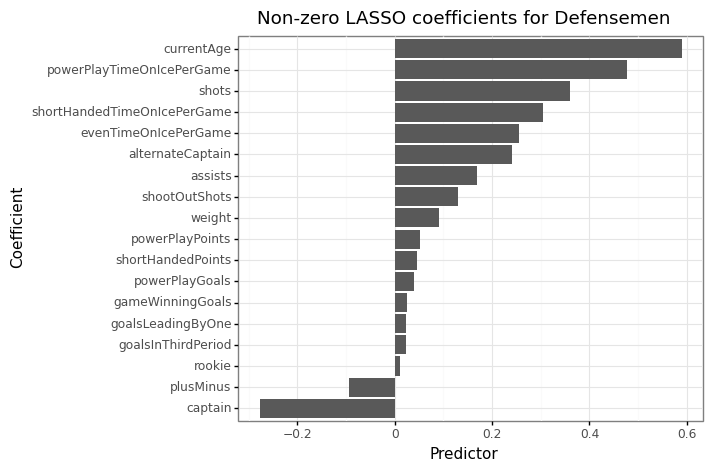

<ggplot: (349598049)>

In [98]:
defense_coefs = pd.DataFrame(zip(full_col_names, best_models[3].coef_), columns=["predictor", "coefficient"])
defense_coefs.sort_values(by=["coefficient"], ignore_index=True, inplace=True)

defense_coefs['predictor'] = pd.Categorical(defense_coefs['predictor'], categories=defense_coefs['predictor'], ordered=True)
# plot of the coefficients for each variable in the model
(
ggplot(data=defense_coefs.query("coefficient != 0"), mapping=aes(x="predictor", y="coefficient")) + 
    geom_bar(stat="identity") + 
    theme_bw() +
    labs(x = "Coefficient", y = "Predictor", title = "Non-zero LASSO coefficients for Defensemen") + 
    coord_flip() 
)

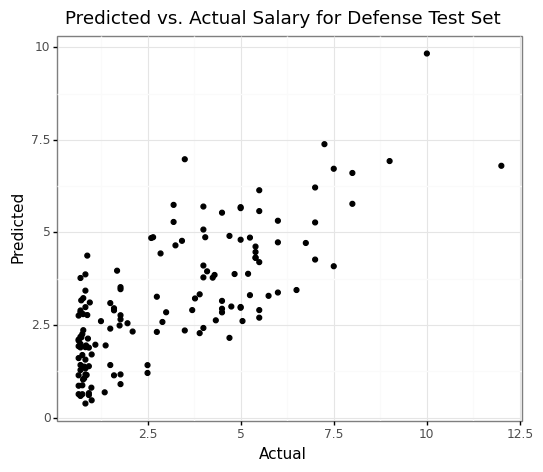

<ggplot: (349821886)>

In [99]:
check_preds = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['true', 'preds'])

(
ggplot(check_preds, aes(x = 'true', y = 'preds')) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Actual", y = "Predicted", title = "Predicted vs. Actual Salary for Defense Test Set")
)

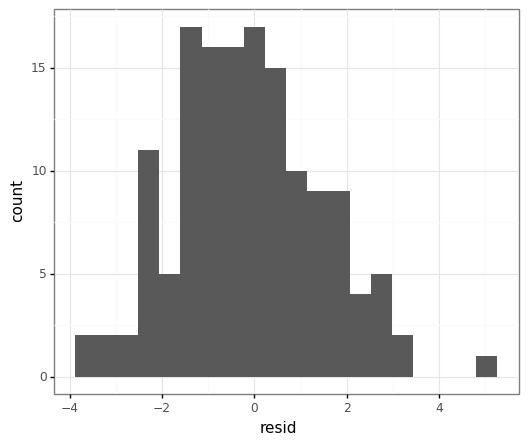

<ggplot: (352970572)>

In [100]:
resid = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['actual', 'preds'])

resid = resid.assign(resid = resid.actual - resid.preds)

(
ggplot(resid, aes(x = "resid")) + 
    geom_histogram(bins = 20) + 
    theme_bw()
)


In [101]:
resid

,actual,preds,resid
0,0.700000,2.186622,-1.486622
1,0.650000,1.610320,-0.960320
2,4.333334,2.629937,1.703397
3,4.700000,2.156244,2.543756
4,1.750000,2.489782,-0.739782
...,...,...,...
138,0.925000,0.612483,0.312517
139,1.775000,2.766637,-0.991637
140,0.925000,0.664081,0.260919
141,0.900000,2.136927,-1.236927


In [102]:
y_train.median()

# train_preds[1]

2.4

In [103]:
test_mse = [mean_squared_error(preds, y_test) for preds in test_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_df = pd.DataFrame(zip(mod_names, test_mse), columns = ['model', "mse"])

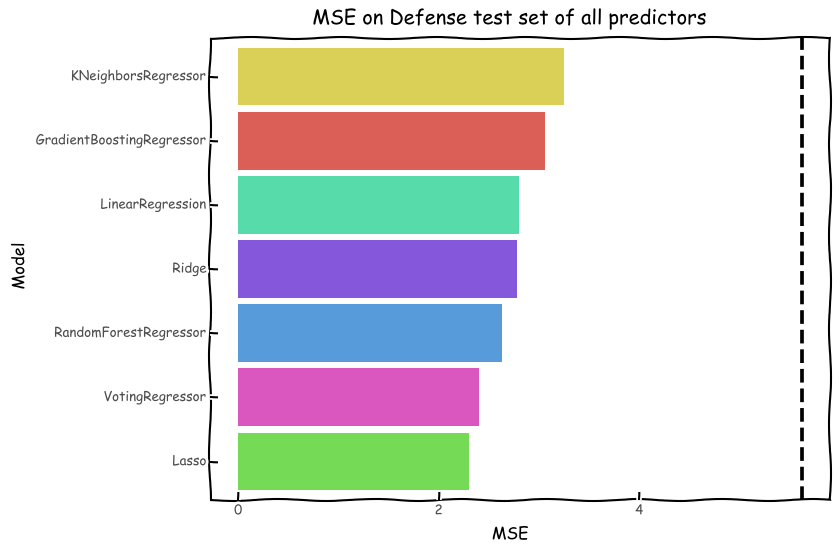

<ggplot: (352603103)>

In [104]:
mean_pred = np.mean((y_test - y_test.mean())**2)

mse_df = mse_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_df['model'], categories=mse_df['model'])

# assign to a new column in the DataFrame
mse_df = mse_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on Defense test set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [105]:
train_mse = [mean_squared_error(preds, y_train) for preds in train_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_train_df = pd.DataFrame(zip(mod_names, train_mse), columns = ['model', "mse"])

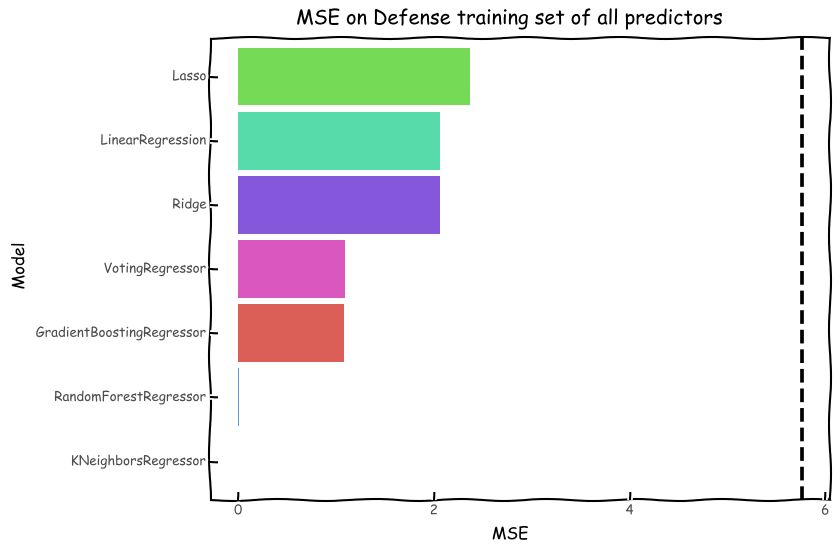

<ggplot: (352985296)>

In [106]:
mean_pred = np.mean((y_train - y_train.mean())**2)

mse_train_df = mse_train_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_train_df['model'], categories=mse_train_df['model'])

# assign to a new column in the DataFrame
mse_train_df = mse_train_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_train_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on Defense training set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

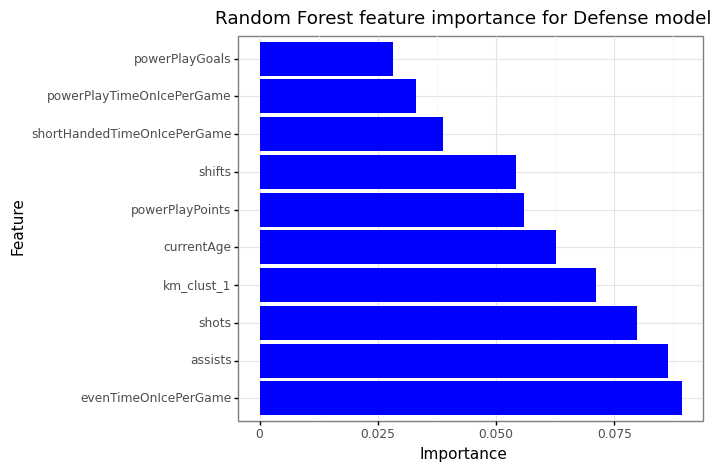

<ggplot: (349660432)>

In [107]:
# top 10 feature importances of the top Random Forest model
rf_features = pd.DataFrame(
    zip(transformer[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.to_list(), 
        best_models[1].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance", title = "Random Forest feature importance for Defense model") + 
    coord_flip() + 
    theme_bw()
)

In [108]:
X_train.groupby('km_clust').median()

,height,weight,rookie,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,blocked,plusMinus,shifts,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,74.0,200.0,0.0,4.0,12.0,34.0,34.0,38.0,0.0,0.0,12.0,0.0,2.700,0.0,0.0,0.0,0.0,35.0,0.0,656.0,14.300,1.200,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
1,74.0,209.5,0.0,29.0,33.5,165.5,72.0,73.0,2.0,11.0,33.5,0.0,5.475,2.0,0.0,0.0,1.0,108.0,3.5,1901.0,18.905,2.050,2.59,2.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0,28.0,0.0,0.0,0.0,0.0
2,74.0,205.0,0.0,14.0,32.0,95.5,68.0,84.0,0.0,1.0,32.0,0.0,4.250,0.0,0.0,0.0,0.0,90.0,1.5,1582.5,17.200,1.855,0.70,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,26.5,0.0,0.0,0.0,0.0


In [109]:
player_df.query("active == False")

,position,team,id,fullName,link,firstName,lastName,primaryNumber,birthDate,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,rookie,shootsCatches,season_type,season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,rosterStatus,goalsInOvertime,goalsTrailingByThreePlus
0,C,New Jersey Devils,8470619,Brian Boyle,/api/v1/people/8470619,Brian,Boyle,9.0,1984-12-18,Hingham,MA,USA,USA,78.0,245,False,False,L,R,20182019,980.80,6,18,38,123,73,145,7,9,192.80,676.00,38,51.05,14.63,4,0,1,2,112.72,50,-14,24,1255,13.43,9.25,1.53,2.62,4.0,6.0,8.0,0.0,1.0,2.0,4.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,33.0,NaN,NaN,NaN,NaN,NaN
1,R,New Jersey Devils,8471226,Drew Stafford,/api/v1/people/8471226,Drew,Stafford,18.0,1985-10-30,Milwaukee,WI,USA,USA,74.0,215,False,False,R,R,20182019,699.13,8,5,18,77,57,50,1,2,50.43,646.45,18,41.02,6.49,0,0,0,0,2.25,19,-7,13,868,12.25,11.33,0.30,0.88,2.0,3.0,NaN,0.0,2.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,0.0,0.0,33.0,NaN,NaN,NaN,NaN,NaN
4,D,New Jersey Devils,8473468,Eric Gryba,/api/v1/people/8473468,Eric,Gryba,2.0,1988-04-14,Saskatoon,SK,CAN,CAN,76.0,222,False,False,R,R,20182019,152.95,0,0,10,11,10,21,0,0,0.12,140.15,10,0.00,0.00,0,0,0,0,12.68,16,-1,0,194,15.28,14.00,1.27,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN
5,D,New Jersey Devils,8473933,Ben Lovejoy,/api/v1/people/8473933,Ben,Lovejoy,21.0,1984-02-20,Concord,NH,USA,USA,73.0,205,False,False,R,R,20182019,1213.13,7,2,37,95,71,76,0,0,3.23,968.88,37,0.00,2.11,0,0,0,0,241.20,118,-1,9,1608,17.80,13.63,3.38,0.30,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN
6,L,New Jersey Devils,8474025,Eric Tangradi,/api/v1/people/8474025,Eric,Tangradi,34.0,1989-02-10,Philadelphia,PA,USA,USA,76.0,226,False,False,L,R,20182019,82.68,1,0,0,10,6,11,0,0,10.62,71.95,0,50.00,0.00,0,0,0,0,0.12,4,-3,1,103,13.77,11.98,0.20,1.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,C,Winnipeg Jets,8476406,Nicholas Shore,/api/v1/people/8476406,Nicholas,Shore,21.0,1992-09-26,Denver,CO,USA,USA,73.0,198,False,False,R,R,20192020,578.28,3,3,20,45,63,55,0,0,2.00,488.13,20,55.26,6.70,0,0,0,0,88.15,20,1,6,875,9.17,7.73,1.38,0.20,2.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN
1890,R,Winnipeg Jets,8481642,Andrei Chibisov,/api/v1/people/8481642,Andrei,Chibisov,76.0,1993-02-26,Prokopyevsk,NaN,RUS,RUS,76.0,227,False,False,L,R,20192020,14.90,0,0,0,1,2,1,0,0,0.00,14.90,0,0.00,0.00,0,0,0,0,0.00,1,0,0,17,7.45,7.45,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN
1896,L,Arizona Coyotes,8473546,Michael Grabner,/api/v1/people/8473546,Michael,Grabner,40.0,1987-10-05,Villach,NaN,AUT,AUT,73.0,188,False,False,L,R,20192020,568.88,3,8,6,61,46,21,0,0,1.47,462.60,6,0.00,13.10,0,0,1,1,104.82,12,-4,11,876,12.37,10.50,2.27,0.20,5.0,2.0,1.0,NaN,NaN,NaN,4.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN
1917,D,Vegas Golden Knights,8468674,Deryk Engelland,/api/v1/people/8468674,Deryk,Engelland,5.0,1982-04-03,Edmonton,AB,CAN,CAN,74.0,212,False,False,R,R,20192020,860.27,5,1,37,59,49,114,0,0,0.60,691.75,37,0